# ARC Dataset Augmentation (Simplified & Visual)

This notebook augments the ARC dataset tasks to create synthetic variations, emphasizing visualization at each step. We start with the original training tasks and apply a series of transformations:

1.  **Copy Originals:** Duplicate the initial dataset into a working directory.
2.  **Geometric Transformations:**
    *   Apply 90, 180, 270-degree rotations.
    *   Apply horizontal mirroring.
3.  **Padding:** Add padding around grids with a random color and width (applied probabilistically).
4.  **Structural Changes:**
    *   Split tasks with multiple test examples into separate tasks, each with a single test example.
5.  **Duplication:** Create a copy of every existing task file (suffix `_c`).
6.  **Randomization:**
    *   Shuffle colors within each task file independently.
    *   Shuffle the order of training examples within each task file.

The code assumes all operations work correctly and focuses on demonstrating the augmentation effects visually.

## Setup: Imports and Helper Functions

Import necessary libraries and define helper functions for visualization, file counting, and path setup.

In [92]:
import json
import os
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import Counter, defaultdict
from tqdm import tqdm
import re
import random

# Matplotlib setup for inline display
%matplotlib inline 

# --- Constants ---
ARC_COLORMAP = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
)
ARC_NORM = colors.Normalize(vmin=0, vmax=9)

# --- Directory Setup ---
# Assumes the original ARC data is in a directory relative to this notebook
data_dir = Path("../ARC-AGI/data/training") 
output_dir = Path("modded_tasks")

# Create the output directory
output_dir.mkdir(parents=True, exist_ok=True)

# --- Grid Display Helper (Minimal checks for plotting) ---
def show_grid(grid, title=None, ax=None):
    """Displays a single ARC grid."""
    # Basic check to prevent imshow error with non-list/empty data
    if not isinstance(grid, list) or not grid or not isinstance(grid[0], list):
       grid_array = np.array([[0]]) # Default to a single black cell
       plot_title = f"{title}\n(Invalid Grid Data)" if title else "(Invalid Grid Data)"
    else:
       grid_array = np.array(grid, dtype=int)
       plot_title = title
       
    height, width = grid_array.shape
    figsize = (max(1, width * 0.4), max(1, height * 0.4))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.imshow(grid_array, cmap=ARC_COLORMAP, norm=ARC_NORM)
    ax.set_xticks(np.arange(-.5, width, 1), minor=True)
    ax.set_yticks(np.arange(-.5, height, 1), minor=True)
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if plot_title:
        ax.set_title(plot_title, fontsize=8)

# --- Visualize Task from File Path (Simplified) ---
def visualize_task_from_path(task_path):
    """Loads a task JSON and visualizes its train/test pairs."""
    task_path = Path(task_path)
    with open(task_path, 'r') as f:
        task_data = json.load(f)
    task_id = task_path.stem
    
    train_examples = task_data.get('train', [])
    test_examples = task_data.get('test', [])
    num_train = len(train_examples)
    num_test = len(test_examples)
    total_cols = num_train + num_test
    if total_cols == 0: 
        print(f"Task {task_id} has no examples to visualize.")
        return
    
    fig_width = min(total_cols * 1.7, 25) 
    fig_height = 4.0
    fig, axs = plt.subplots(2, total_cols, figsize=(fig_width, fig_height), squeeze=False)
    plt.suptitle(f"Task: {task_id}", fontsize=12, y=1.0)
    
    # Plot training examples
    for i, ex in enumerate(train_examples):
        show_grid(ex.get('input'), f"Tr {i+1} In", ax=axs[0, i])
        show_grid(ex.get('output'), f"Tr {i+1} Out", ax=axs[1, i])
            
    # Plot test examples
    for i, ex in enumerate(test_examples):
        col = num_train + i
        show_grid(ex.get('input'), f"Te {i+1} In", ax=axs[0, col])
        out_title = f"Te {i+1} Out"
        # Plot output if it exists, otherwise mark as '?'
        if 'output' in ex:
            show_grid(ex.get('output'), out_title, ax=axs[1, col])
        else: 
            axs[1, col].set_title(f"{out_title}\n(No Output)", fontsize=8)
            axs[1, col].imshow([[0]], cmap='Greys', vmin=0, vmax=1) # Show empty gray box
            axs[1, col].set_xticks([])
            axs[1, col].set_yticks([])
            
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
    plt.close(fig) 

# --- Visualize All Variants of a Task ID ---
def visualize_task_variants(base_task_id, tasks_dir):
    """Visualizes all task files starting with the base_task_id."""
    tasks_dir = Path(tasks_dir)
    print(f"\n--- Visualizing variants for Task ID: {base_task_id} in '{tasks_dir.name}' ---")
    variant_files = sorted(tasks_dir.glob(f"{base_task_id}*.json"))
    
    print(f"Found {len(variant_files)} variants.")
    # Limit visualization if too many variants
    max_variants_to_show = 20 
    if len(variant_files) > max_variants_to_show:
        print(f"(Showing first {max_variants_to_show})" )
        variant_files = variant_files[:max_variants_to_show]
        
    for task_path in variant_files:
        visualize_task_from_path(task_path)

# --- Visualize First Train Example Variants Side-by-Side ---
def plot_first_train_example_variants(base_task_id, task_directory):
    """Plots the first training example for all variants side-by-side."""
    task_directory = Path(task_directory)
    print(f"\n--- Visualizing first train example variants side-by-side for Task ID: {base_task_id} ---")
    variant_filepaths = sorted(list(task_directory.glob(f"{base_task_id}*.json")))
    variant_count = len(variant_filepaths)
    if variant_count == 0:
        print(f"No variants found for {base_task_id}")
        return
    print(f"Found {variant_count} variants to plot.")

    figure_width = min(variant_count * 1.8, 45) 
    figure_height = 5.0
    fig, axes = plt.subplots(2, variant_count, figsize=(figure_width, figure_height), squeeze=False)
    plt.suptitle(f"Task: {base_task_id} - First Train Example Variants", fontsize=14, y=1.0)

    for i, variant_path in enumerate(variant_filepaths):
        with open(variant_path, 'r') as f:
            task_data = json.load(f)
        
        train_examples = task_data.get('train', [])
        if not train_examples: # Handle missing train data
           input_grid, output_grid = [[0]], [[0]]
           variant_label = f"{variant_path.stem.replace(base_task_id, '').strip('_') or 'Original'}\n(No Train)"
        else:
           first_train_example = train_examples[0]
           input_grid = first_train_example.get('input', [[0]])
           output_grid = first_train_example.get('output', [[0]])
           variant_stem = variant_path.stem
           variant_suffix = variant_stem.replace(base_task_id, '', 1).strip('_')
           if not variant_suffix:
               variant_label = "Original"
           else:
               parts = sorted(variant_suffix.split('_'))
               variant_label = '_'.join(parts)

        show_grid(input_grid, title=None, ax=axes[0, i])
        axes[0, i].set_xlabel(f"{variant_label}\nInput", fontsize=9)
        axes[0, i].xaxis.set_label_position('top') 

        show_grid(output_grid, title=None, ax=axes[1, i])
        axes[1, i].set_xlabel("Output", fontsize=9) 

    plt.tight_layout(rect=[0, 0.05, 1, 0.93], h_pad=3) 
    plt.show()
    plt.close(fig)

# --- File Counter ---
def count_json_files(folder):
    """Counts the number of .json files in a directory."""
    folder = Path(folder)
    return len(list(folder.glob('*.json')))

print(f"Setup complete. Using data from: {data_dir}")
print(f"Outputting augmented tasks to: {output_dir}")

# --- Select an example task ID for consistent visualization ---
# This ID is chosen because it's simple and shows transformations well.
example_vis_id = "8dab14c2" # Replace with another ID if preferred
print(f"Will use Task ID '{example_vis_id}' for detailed visualizations.")

Setup complete. Using data from: ..\ARC-AGI\data\training
Outputting augmented tasks to: modded_tasks
Will use Task ID '8dab14c2' for detailed visualizations.


## 1. Copy Original Tasks

Copy original task files to the working directory.

In [93]:
# Clear output directory first to ensure a clean start
if output_dir.exists():
    print(f"Clearing existing output directory: {output_dir}")
    shutil.rmtree(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

original_task_paths = sorted(data_dir.glob("*.json"))

print(f"Copying {len(original_task_paths)} original tasks from '{data_dir}' to '{output_dir}'...")
for src_path in tqdm(original_task_paths, desc="Copying originals"):
    dest_path = output_dir / src_path.name
    shutil.copy2(src_path, dest_path) 
        
print(f"Copy complete. Files in '{output_dir.name}': {count_json_files(output_dir)}")

Clearing existing output directory: modded_tasks
Copying 1000 original tasks from '..\ARC-AGI\data\training' to 'modded_tasks'...


Copying originals: 100%|██████████| 1000/1000 [00:01<00:00, 677.81it/s]

Copy complete. Files in 'modded_tasks': 1000


Visualize the example task in its original form.

Visualizing the original example task: 8dab14c2.json


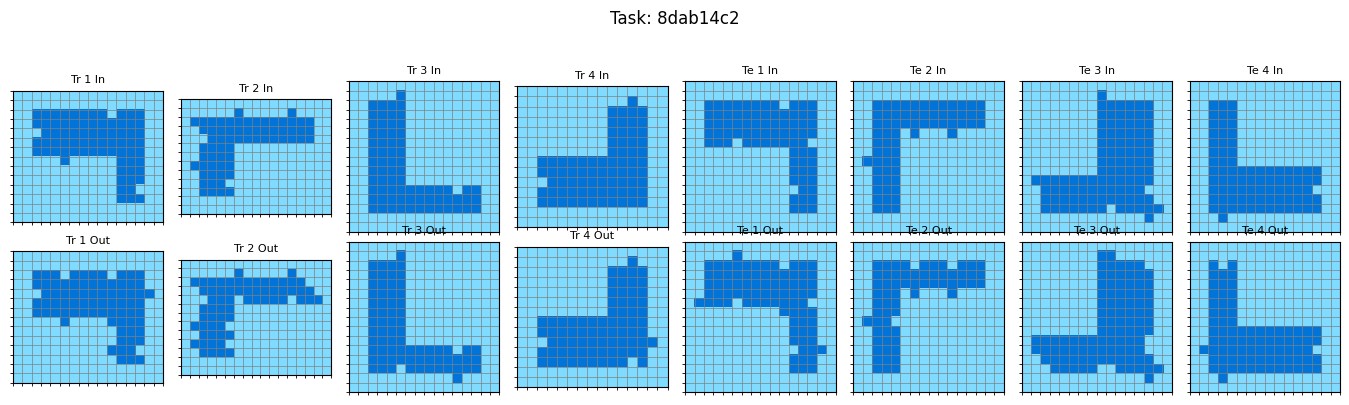

In [94]:
example_task_path = output_dir / f"{example_vis_id}.json"
print(f"Visualizing the original example task: {example_task_path.name}")
visualize_task_from_path(example_task_path)

## Task Distribution Analysis (Optional Context)

Analyze the train/test example distribution in the copied dataset.


--- Analyzing task distribution in: modded_tasks ---


Analyzing tasks in modded_tasks: 100%|██████████| 1000/1000 [00:00<00:00, 2130.26it/s]


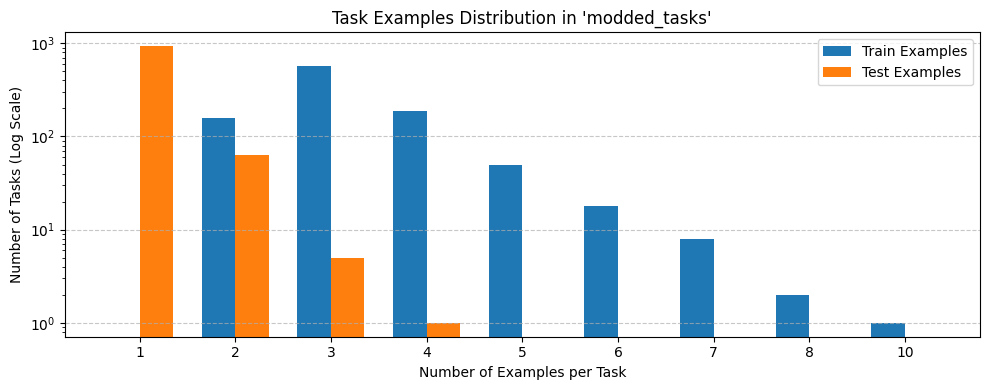


--- Summary Statistics ---
Total tasks analyzed: 1000
Total training examples: 3232
Total test examples: 1076
Average train examples per task: 3.23
Average test examples per task: 1.08
--- Analysis complete ---


In [95]:
def plot_task_distribution_simple(task_directory):
    """Analyzes and plots the distribution of train/test examples.
       (Code identical to setup cell, placed here for context)
    """
    task_directory = Path(task_directory)
    print(f"\n--- Analyzing task distribution in: {task_directory.name} ---")
    train_counts = []
    test_counts = []
    task_files = sorted(task_directory.glob("*.json"))
    if not task_files:
        print("No .json files found.")
        return

    total_tasks_analyzed = 0
    total_train_examples = 0
    total_test_examples = 0
    for task_path in tqdm(task_files, desc=f"Analyzing tasks in {task_directory.name}"):
        with open(task_path, 'r') as f:
            data = json.load(f)
        num_train = len(data.get('train', []))
        num_test = len(data.get('test', []))
        train_counts.append(num_train)
        test_counts.append(num_test)
        total_train_examples += num_train
        total_test_examples += num_test
        total_tasks_analyzed += 1

    train_hist = Counter(train_counts)
    test_hist = Counter(test_counts)
    all_counts = sorted(list(set(train_hist.keys()).union(test_hist.keys())))
    if not all_counts:
        print("No example counts found to plot.")
    else:
        train_vals = [train_hist.get(x, 0) for x in all_counts]
        test_vals = [test_hist.get(x, 0) for x in all_counts]
        x_indices = np.arange(len(all_counts))
        plt.figure(figsize=(10, 4))
        bar_width = 0.35
        plt.bar(x_indices - bar_width/2, train_vals, bar_width, label='Train Examples')
        plt.bar(x_indices + bar_width/2, test_vals, bar_width, label='Test Examples')
        plt.xlabel("Number of Examples per Task")
        plt.ylabel("Number of Tasks (Log Scale)")
        plt.title(f"Task Examples Distribution in '{task_directory.name}'")
        plt.xticks(x_indices, all_counts)
        plt.yscale("log")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    print("\n--- Summary Statistics ---")
    print(f"Total tasks analyzed: {total_tasks_analyzed}")
    print(f"Total training examples: {total_train_examples}")
    print(f"Total test examples: {total_test_examples}")
    if total_tasks_analyzed > 0:
        avg_train = total_train_examples / total_tasks_analyzed
        avg_test = total_test_examples / total_tasks_analyzed
        print(f"Average train examples per task: {avg_train:.2f}")
        print(f"Average test examples per task: {avg_test:.2f}")
    print("--- Analysis complete ---")

plot_task_distribution_simple(output_dir)

## 2. Geometric Augmentation: Rotations

Apply 90, 180, 270-degree rotations to the original task files.

Applying rotations to tasks in 'modded_tasks'...


Rotating tasks: 100%|██████████| 1000/1000 [00:16<00:00, 62.01it/s]


Rotation complete. Added 3000 rotated task files.
Total files in 'modded_tasks': 4000

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 4 variants.


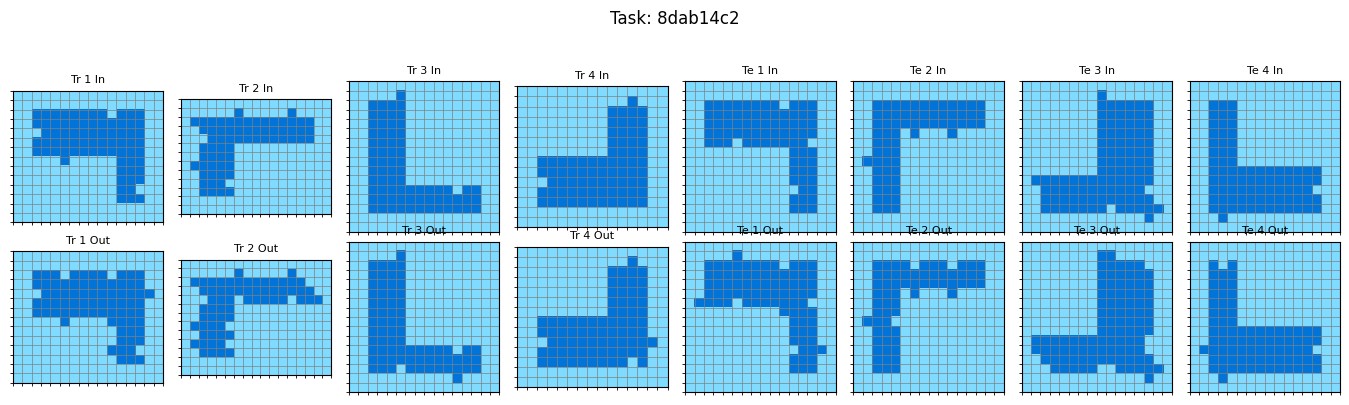

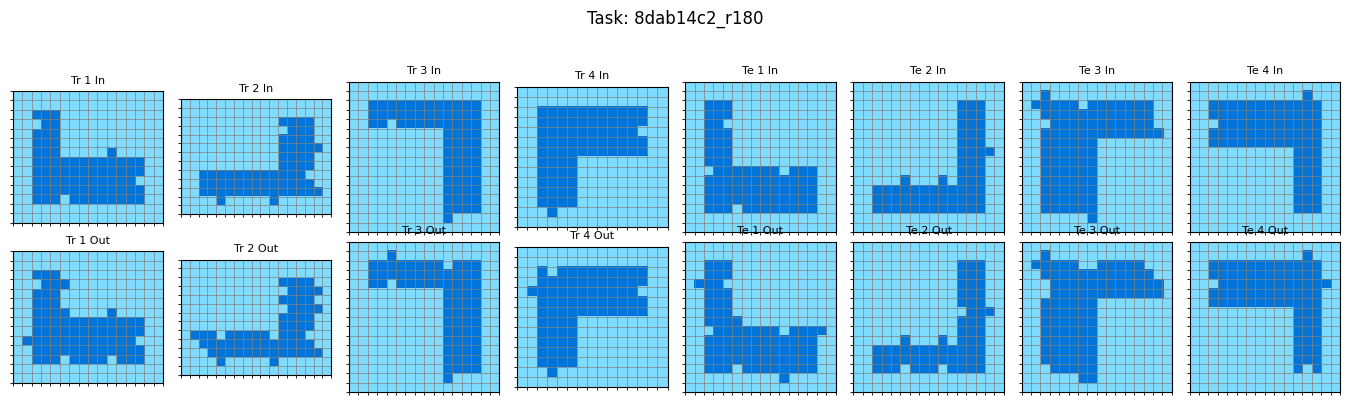

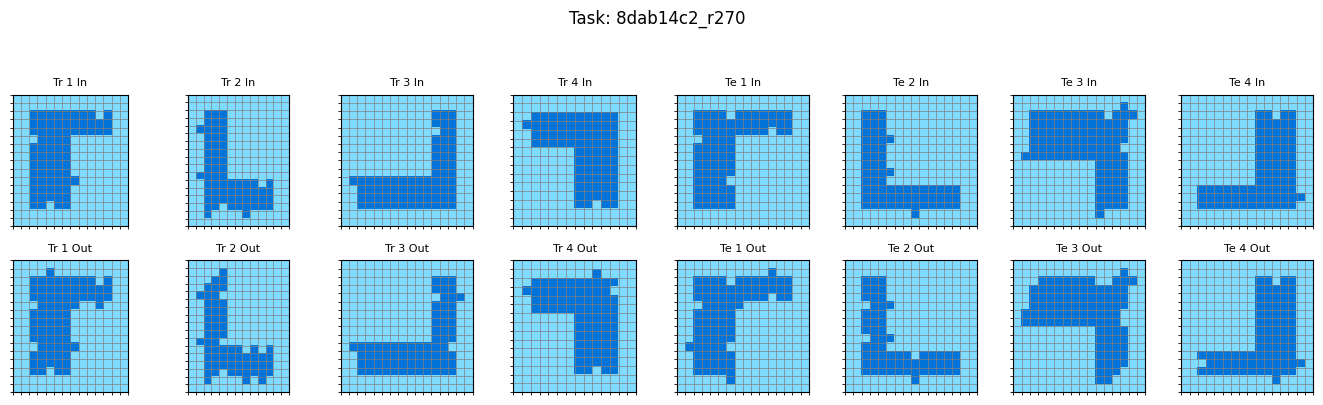

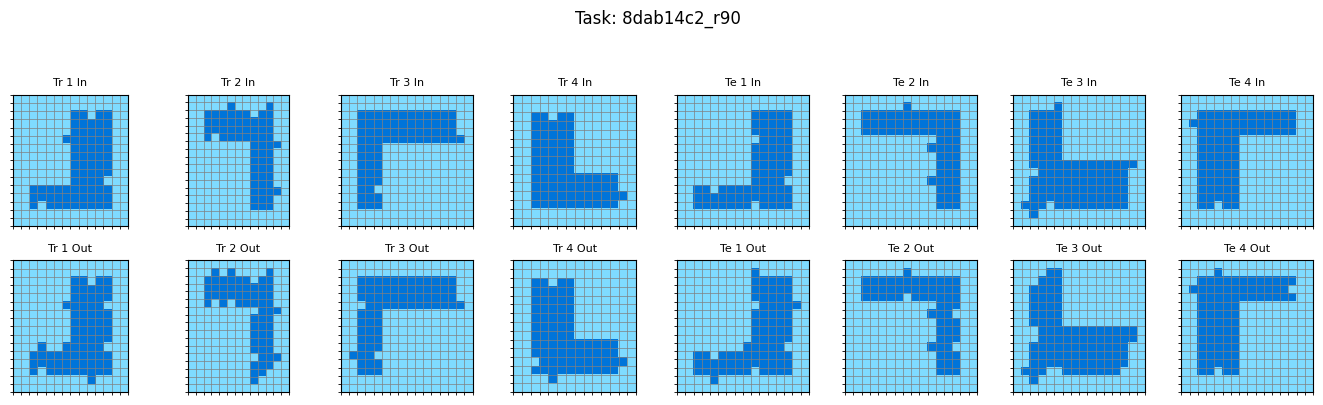

In [96]:
def rotate_grid(grid, angle):
    """Rotates a grid (list of lists) by 90, 180, or 270 degrees."""
    # Assumes grid is valid list of lists
    arr = np.array(grid)
    if angle == 90: k = 3 
    elif angle == 180: k = 2
    elif angle == 270: k = 1
    else: return grid 
    return np.rot90(arr, k).tolist()

print(f"Applying rotations to tasks in '{output_dir.name}'...")

original_filenames = [
    f for f in output_dir.iterdir() 
    if f.is_file() and f.suffix == '.json' and '_' not in f.stem
]

rotation_count = 0
for task_path in tqdm(original_filenames, desc="Rotating tasks"):
    task_id = task_path.stem
    with open(task_path, 'r') as f:
        task_data = json.load(f)
    
    for angle in [90, 180, 270]:
        rotated_data = {'train': [], 'test': []}
        for pair in task_data.get('train', []):
            rotated_data['train'].append({
                'input': rotate_grid(pair.get('input'), angle),
                'output': rotate_grid(pair.get('output'), angle)
            })
        for pair in task_data.get('test', []):
            rotated_pair = {'input': rotate_grid(pair.get('input'), angle)}
            if 'output' in pair: # Check if output exists before rotating
                 rotated_pair['output'] = rotate_grid(pair.get('output'), angle)
            rotated_data['test'].append(rotated_pair)
                
        rot_filename = f"{task_id}_r{angle}.json"
        rot_filepath = output_dir / rot_filename
        with open(rot_filepath, 'w') as f_out:
            json.dump(rotated_data, f_out)
        rotation_count += 1

print(f"Rotation complete. Added {rotation_count} rotated task files.")
print(f"Total files in '{output_dir.name}': {count_json_files(output_dir)}")

# Visualize variants after rotation
visualize_task_variants(example_vis_id, output_dir)

## 3. Geometric Augmentation: Horizontal Mirroring

Apply horizontal mirroring to all files not already mirrored (`_mh`).

Applying HORIZONTAL mirroring to tasks in 'modded_tasks'...


Horizontally Mirroring tasks: 100%|██████████| 4000/4000 [00:22<00:00, 176.76it/s]


Horizontal Mirroring complete. Added 4000 mirrored task files.
Total files in 'modded_tasks': 8000

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 8 variants.


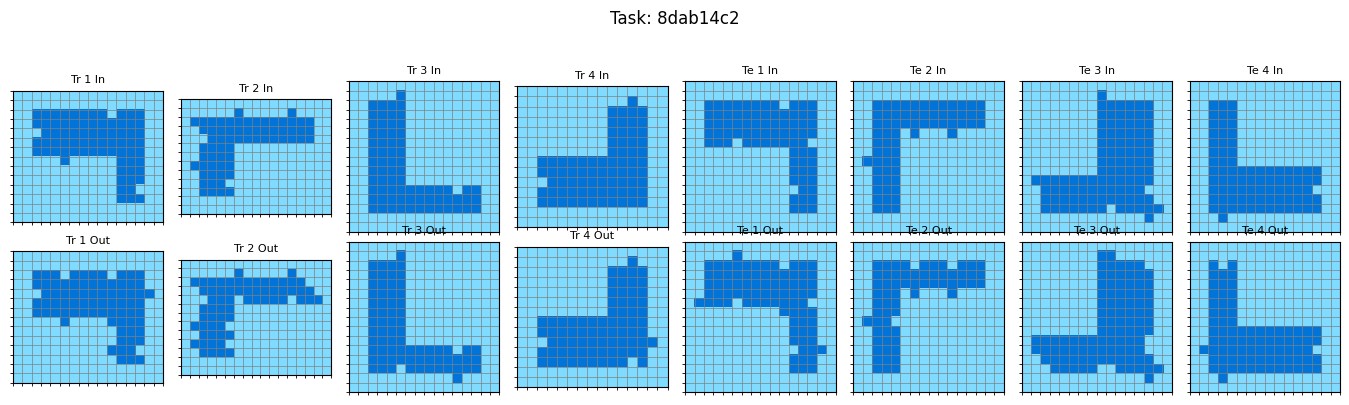

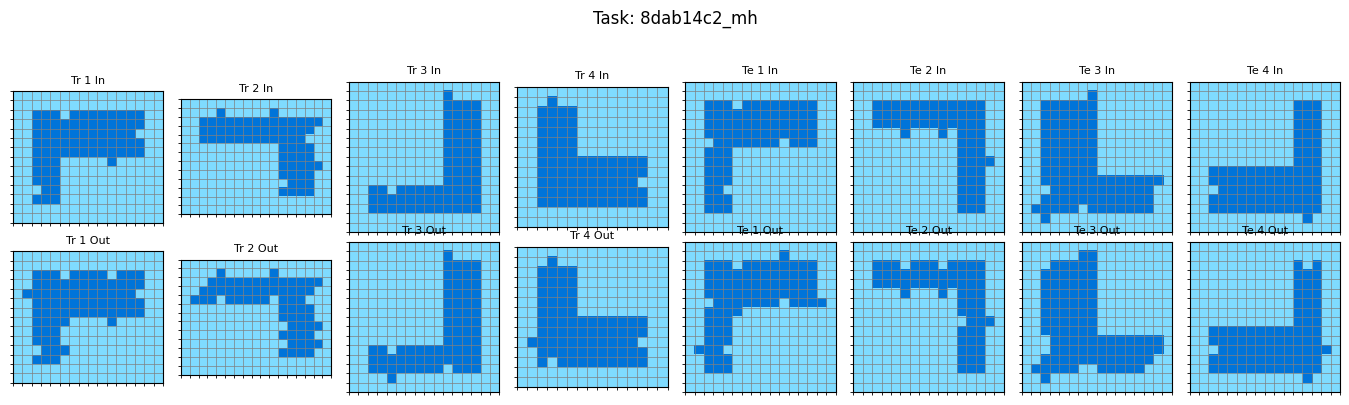

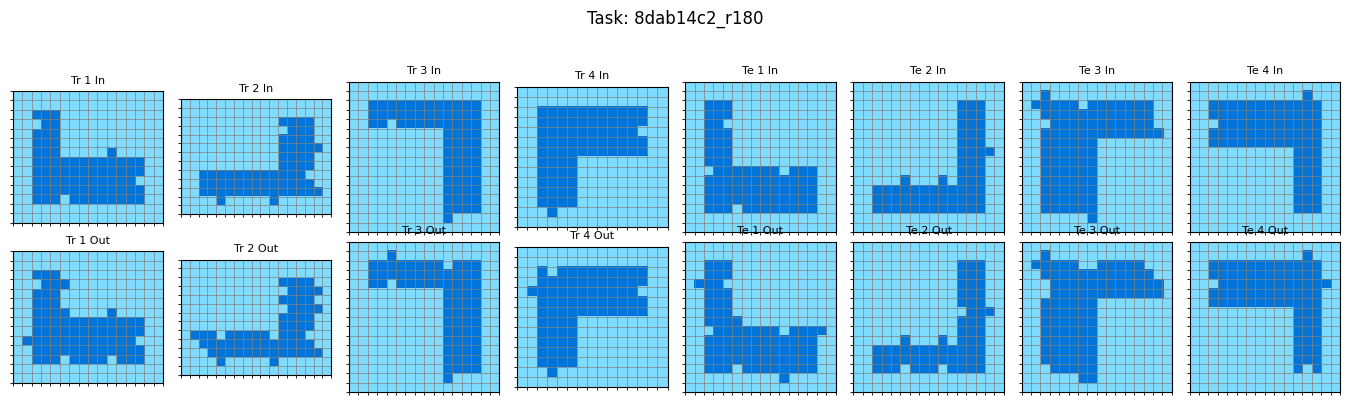

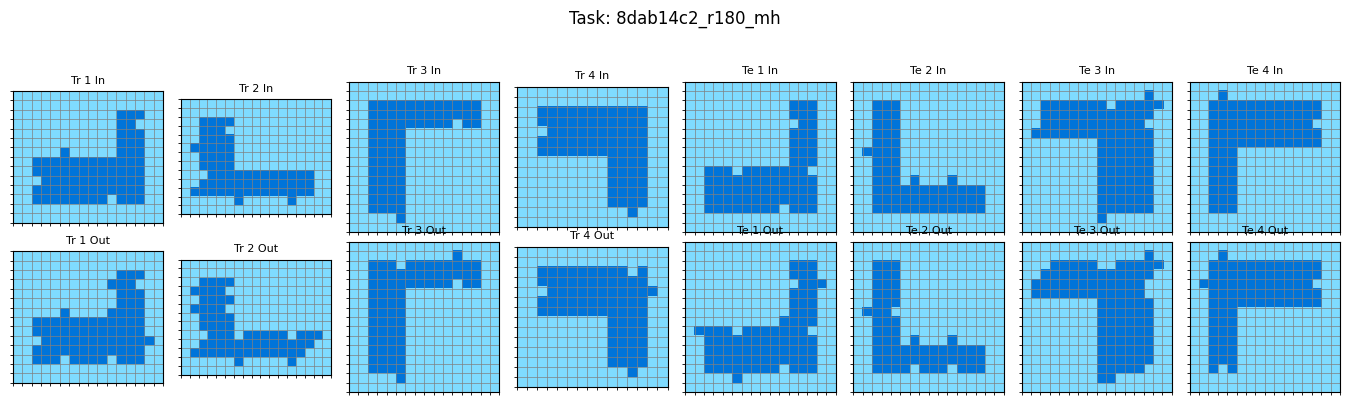

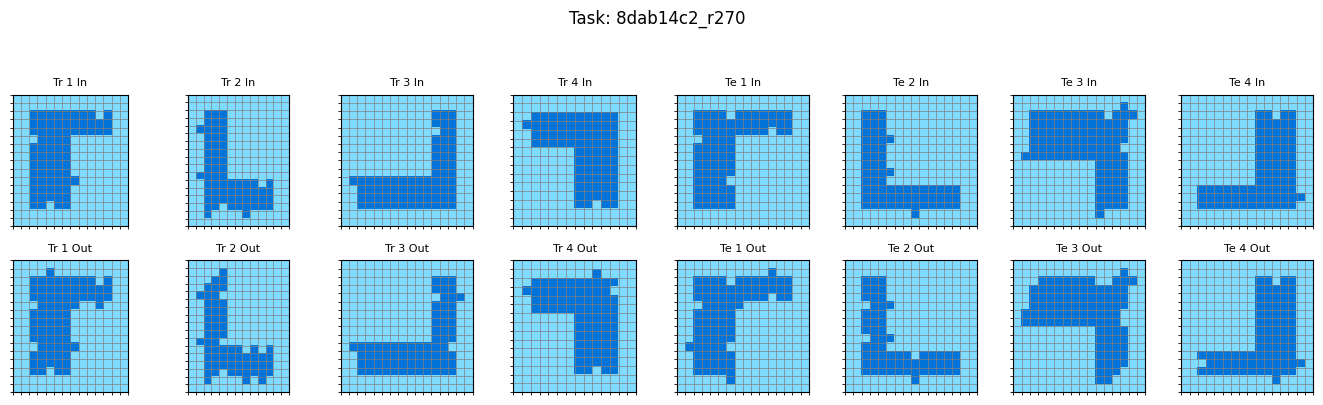

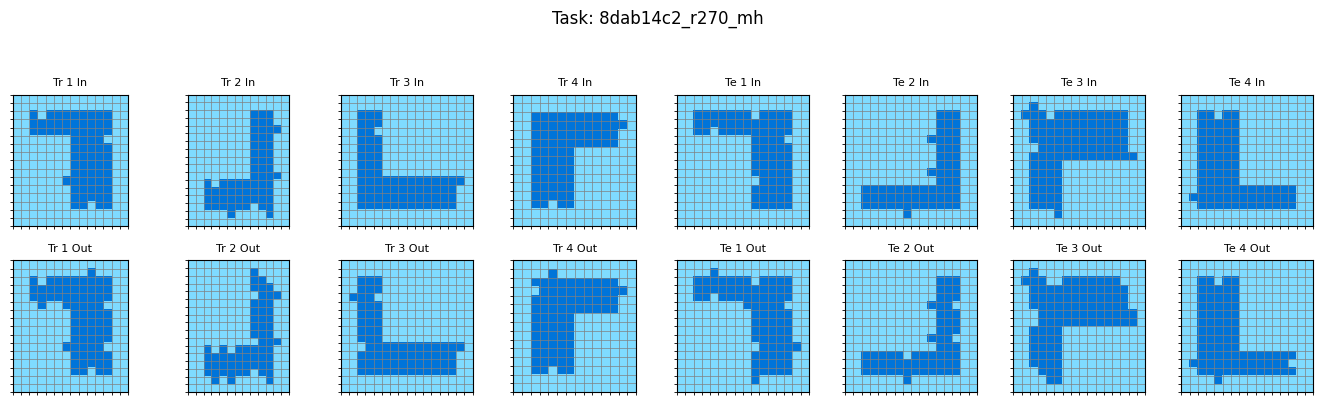

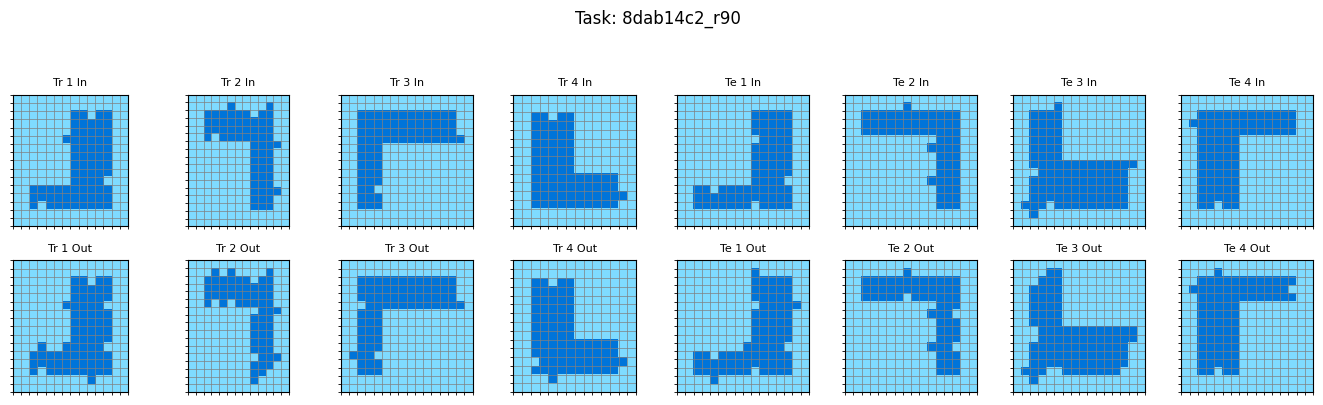

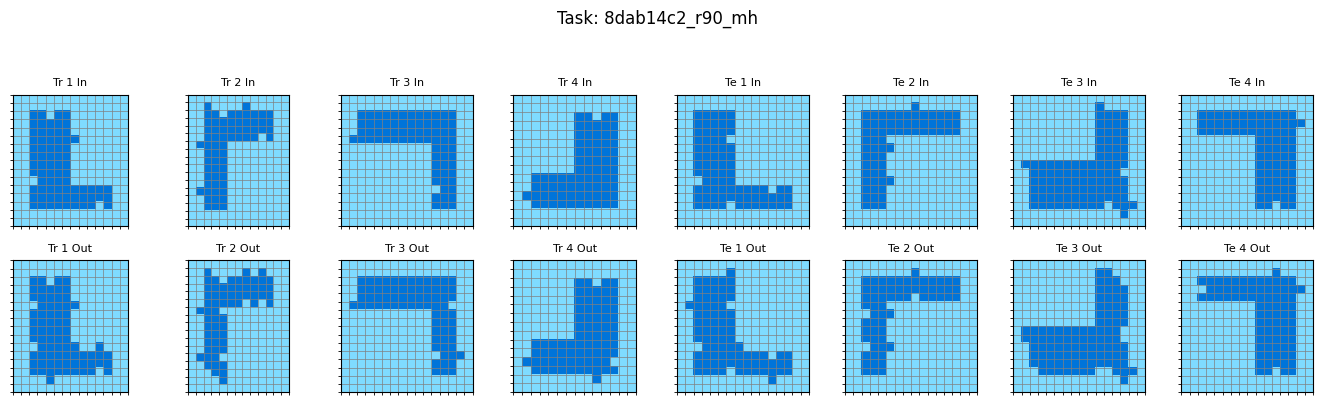


--- Visualizing first train example variants side-by-side for Task ID: 8dab14c2 ---
Found 8 variants to plot.


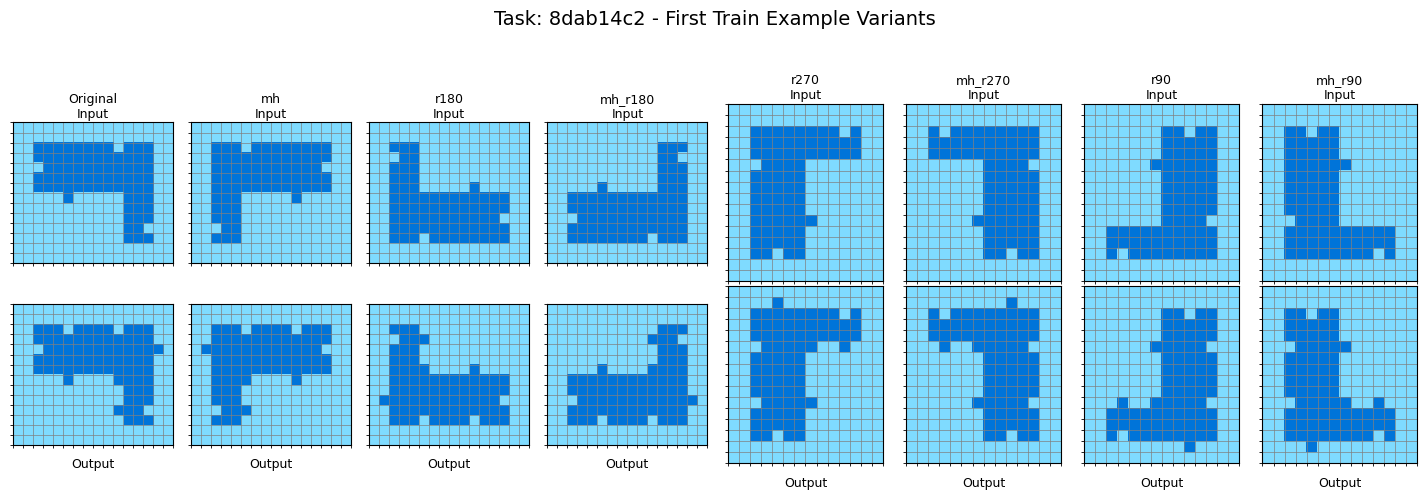

In [97]:
def mirror_grid(grid, direction='h'):
    """Mirrors a grid horizontally ('h')."""
    # Assumes grid is valid list of lists
    arr = np.array(grid)
    if direction == 'h': return np.fliplr(arr).tolist()
    return grid # Only implementing horizontal

print(f"Applying HORIZONTAL mirroring to tasks in '{output_dir.name}'...")

files_to_mirror = sorted([
    f for f in output_dir.iterdir()
    if f.is_file() and f.suffix == '.json' and '_mh' not in f.stem
])

mirror_count = 0
for task_path in tqdm(files_to_mirror, desc="Horizontally Mirroring tasks"):
    task_id_base = task_path.stem
    with open(task_path, 'r') as f:
        task_data = json.load(f)

    mirrored_data = {'train': [], 'test': []}
    for pair in task_data.get('train', []):
        mirrored_data['train'].append({
            'input': mirror_grid(pair.get('input'), 'h'),
            'output': mirror_grid(pair.get('output'), 'h')
        })
    for pair in task_data.get('test', []):
        mirrored_pair = {'input': mirror_grid(pair.get('input'), 'h')}
        if 'output' in pair:
             mirrored_pair['output'] = mirror_grid(pair.get('output'), 'h')
        mirrored_data['test'].append(mirrored_pair)
            
    mir_filename = f"{task_id_base}_mh.json"
    mir_filepath = output_dir / mir_filename
    with open(mir_filepath, 'w') as f_out:
        json.dump(mirrored_data, f_out)
    mirror_count += 1

print(f"Horizontal Mirroring complete. Added {mirror_count} mirrored task files.")
print(f"Total files in '{output_dir.name}': {count_json_files(output_dir)}")

# Visualize variants after mirroring
visualize_task_variants(example_vis_id, output_dir)

# Visualize side-by-side comparison after mirroring
plot_first_train_example_variants(example_vis_id, output_dir)

## Check for Duplicate Task Content

Check if any transformations resulted in identical task files.

In [98]:
def check_duplicates(tasks_dir):
    """Checks for duplicate task content by comparing JSON strings.
       (Code identical to previous version, placed here for context)
    """
    tasks_dir = Path(tasks_dir)
    print(f"\n--- Checking for duplicate task content in '{tasks_dir.name}' ---")
    content_map = defaultdict(list)
    json_files = list(tasks_dir.glob('*.json'))
    for filepath in tqdm(json_files, desc="Checking duplicates"):
        with open(filepath, 'r') as f:
            data = json.load(f)
        canonical_repr = json.dumps(data, sort_keys=True)
        content_map[canonical_repr].append(filepath.name)
    duplicate_sets = {k: v for k, v in content_map.items() if len(v) > 1}
    if duplicate_sets:
        num_duplicate_contents = len(duplicate_sets)
        num_duplicate_files = sum(len(files) for files in duplicate_sets.values())
        print(f"Found {num_duplicate_contents} sets of duplicate task content, involving {num_duplicate_files} files.")
    else:
        print("No duplicate task content found.")
    return duplicate_sets

duplicates = check_duplicates(output_dir)
print("Duplicate check complete.")


--- Checking for duplicate task content in 'modded_tasks' ---


Checking duplicates: 100%|██████████| 8000/8000 [00:04<00:00, 1627.01it/s]

Found 80 sets of duplicate task content, involving 192 files.
Duplicate check complete.


*(Note: Duplicates are detected but not removed.)*

## 4. Padding Augmentation

Add padding probabilistically to task files that don't already have padding.

Applying conditional padding to tasks in 'modded_tasks'...


Padding tasks: 100%|██████████| 8000/8000 [00:38<00:00, 207.15it/s]



Conditional Padding complete. Created 5999 new padded files.
Total files in 'modded_tasks': 13999

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 15 variants.


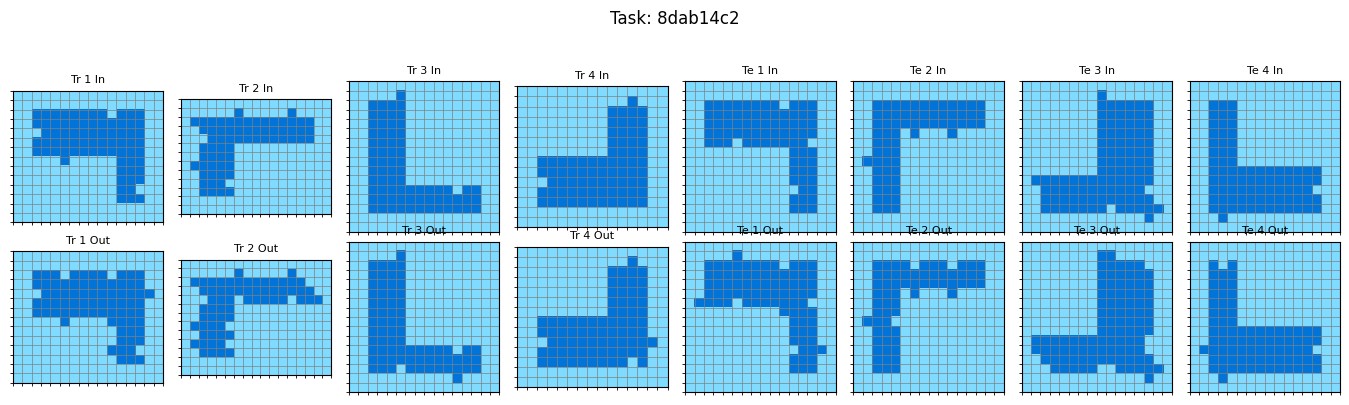

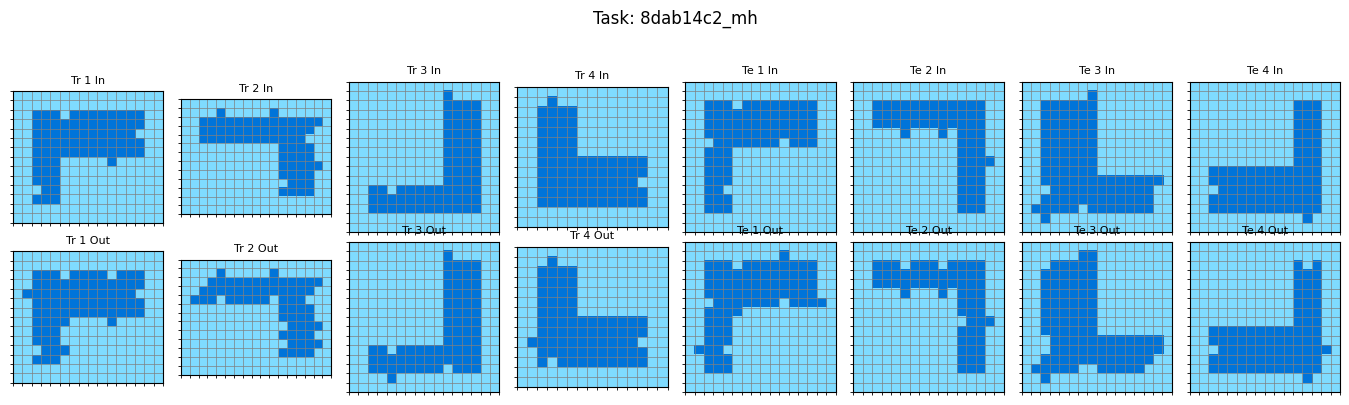

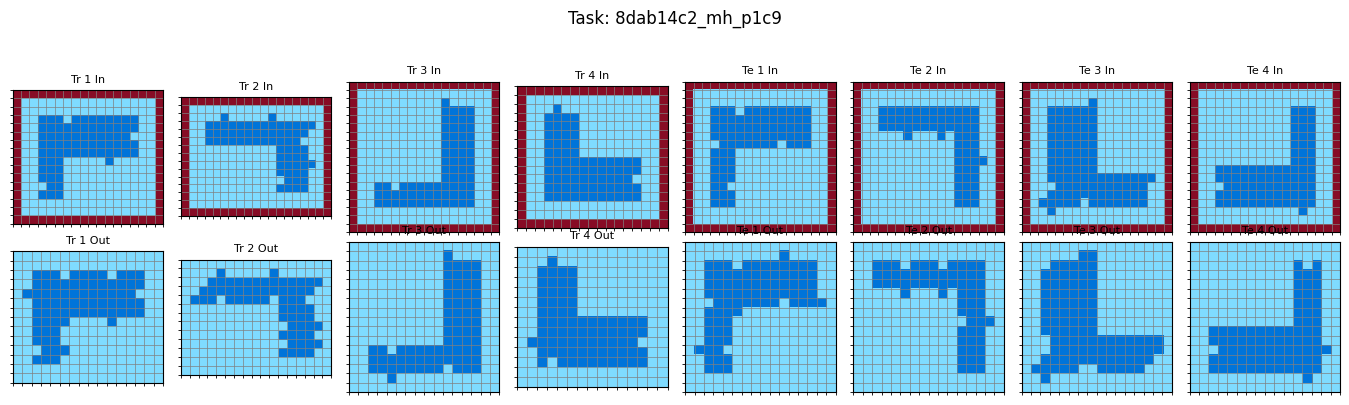

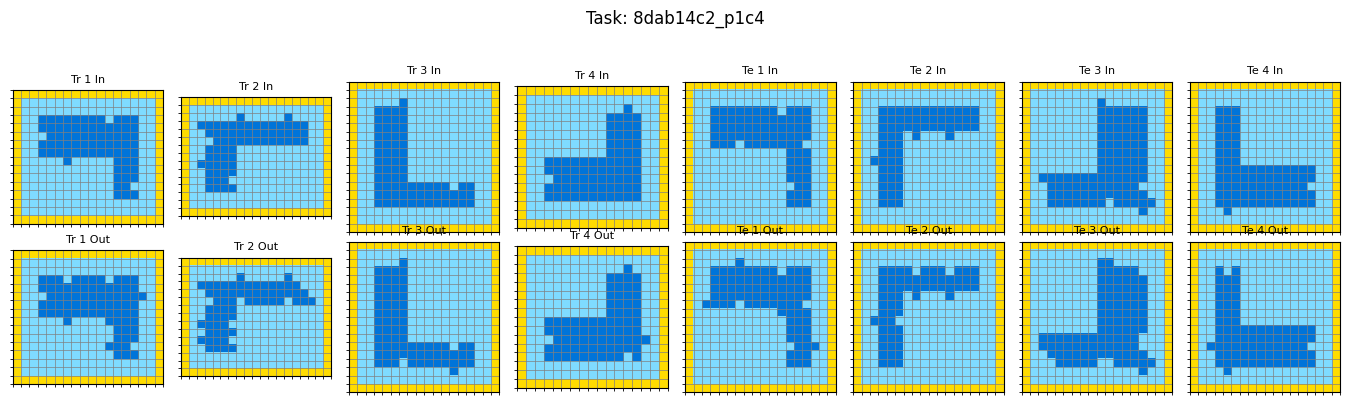

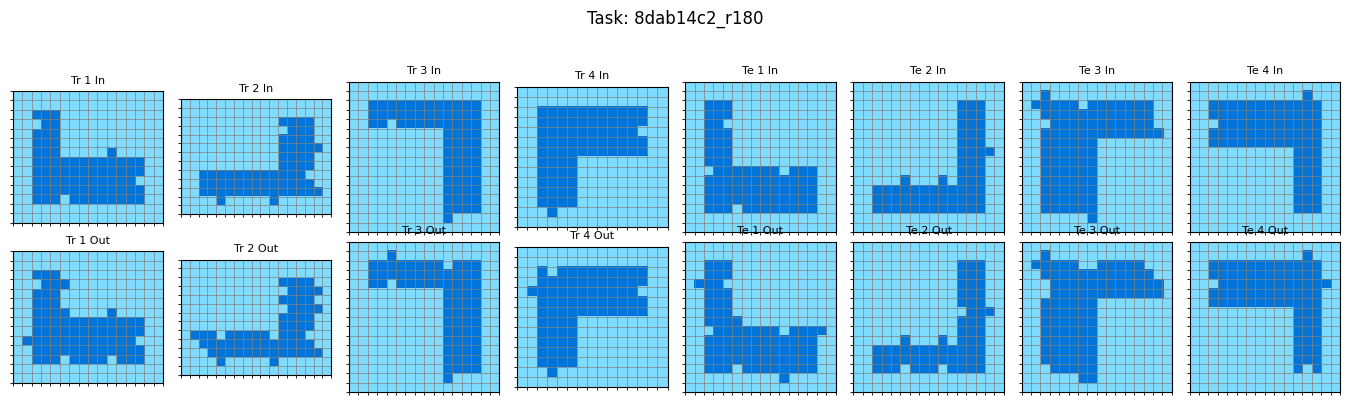

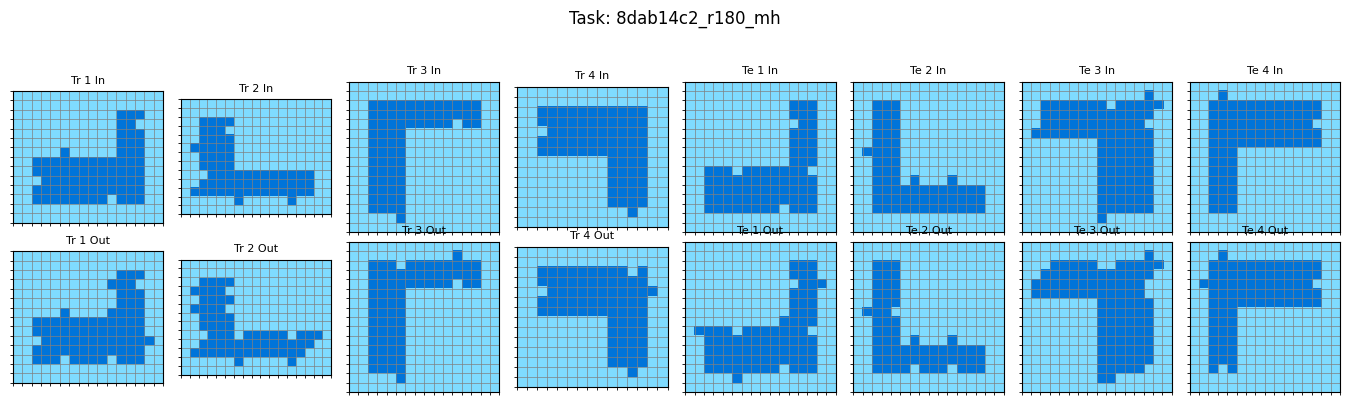

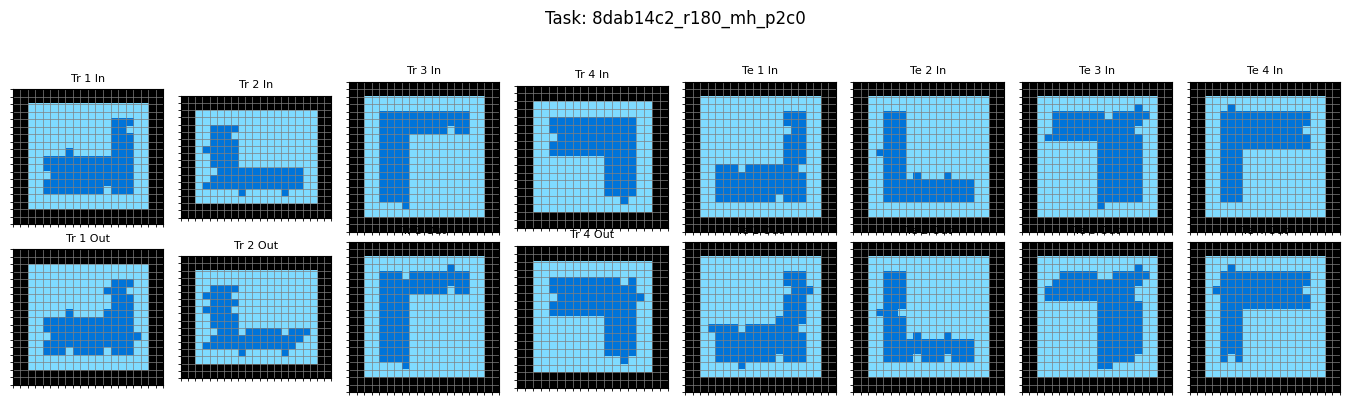

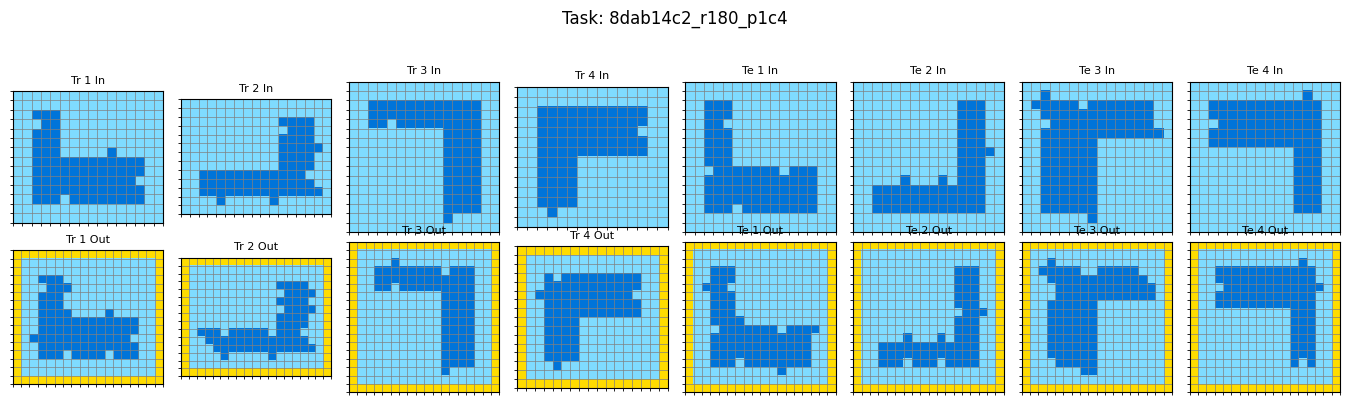

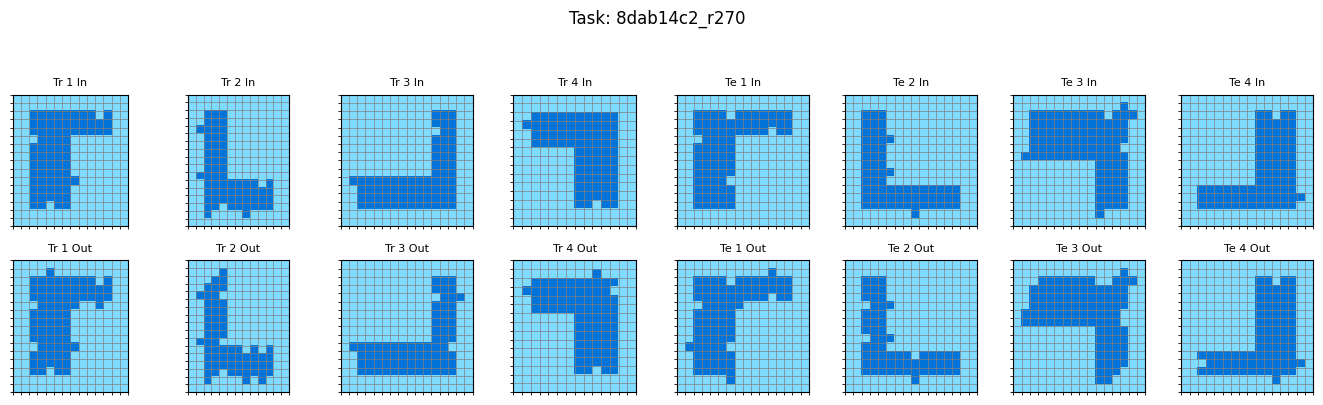

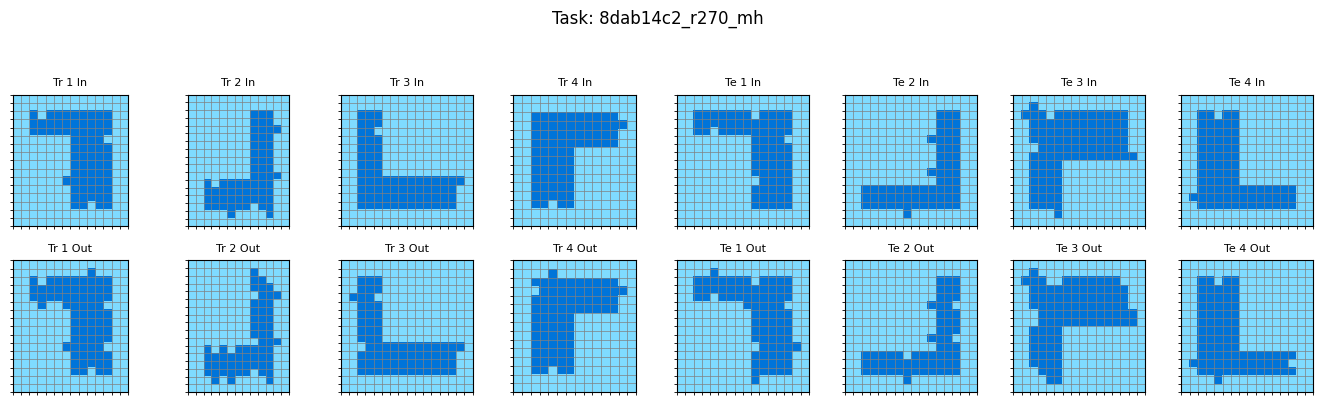

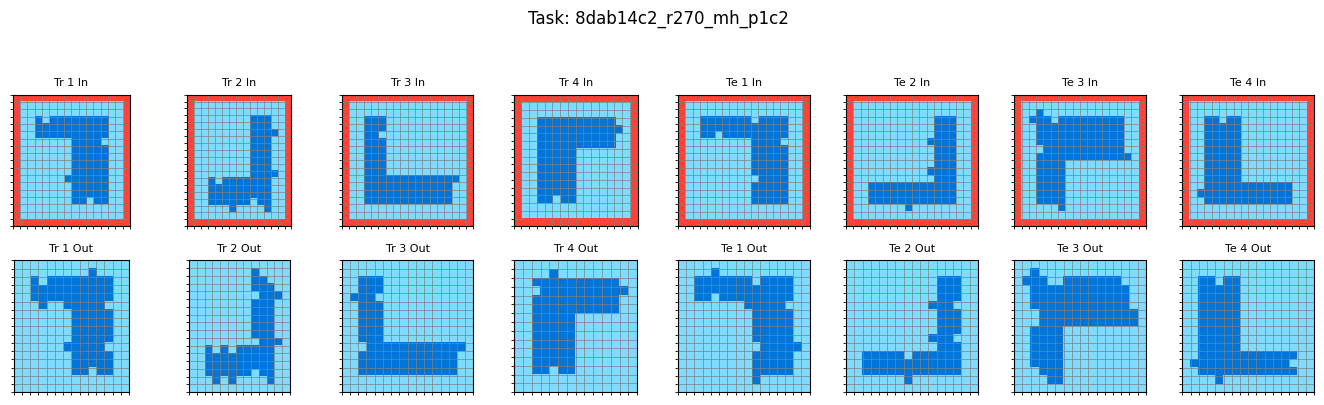

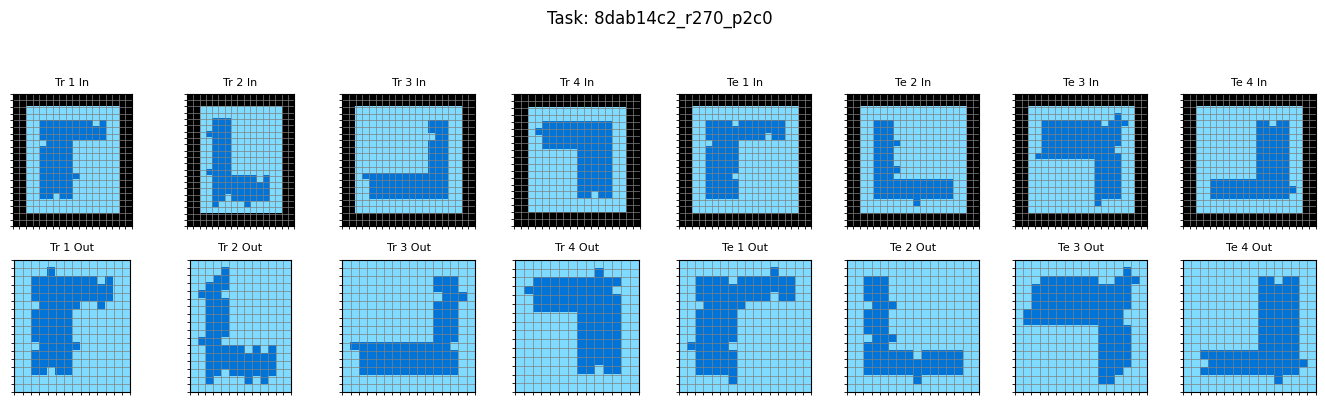

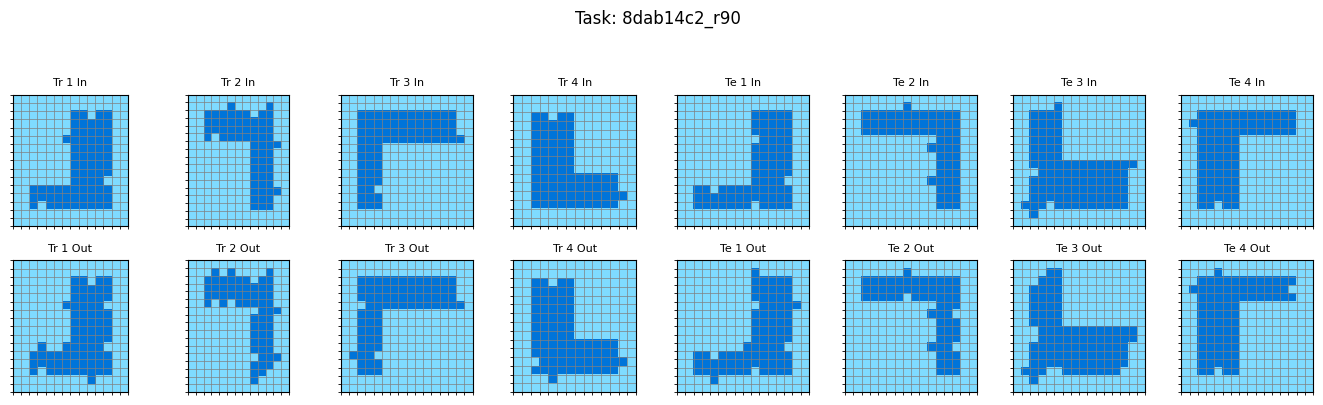

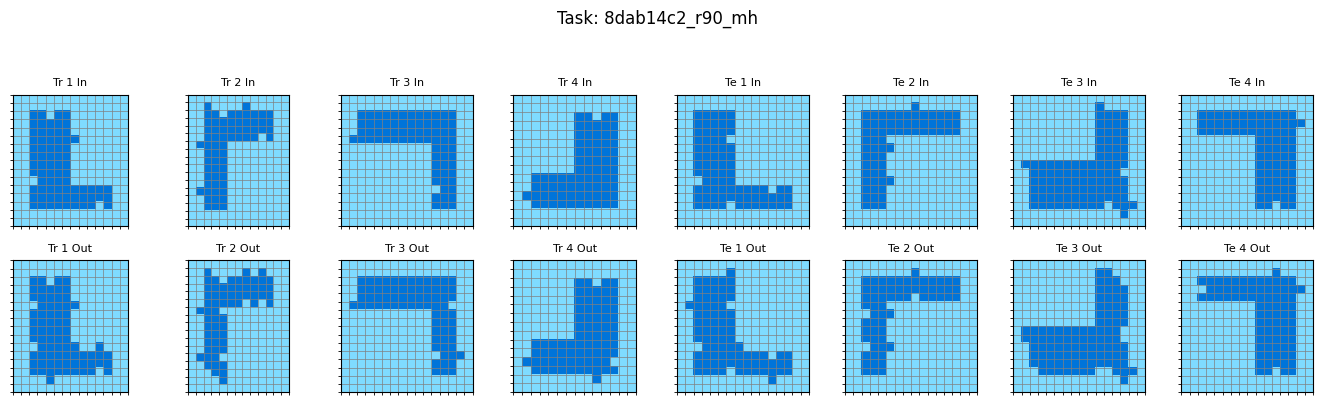

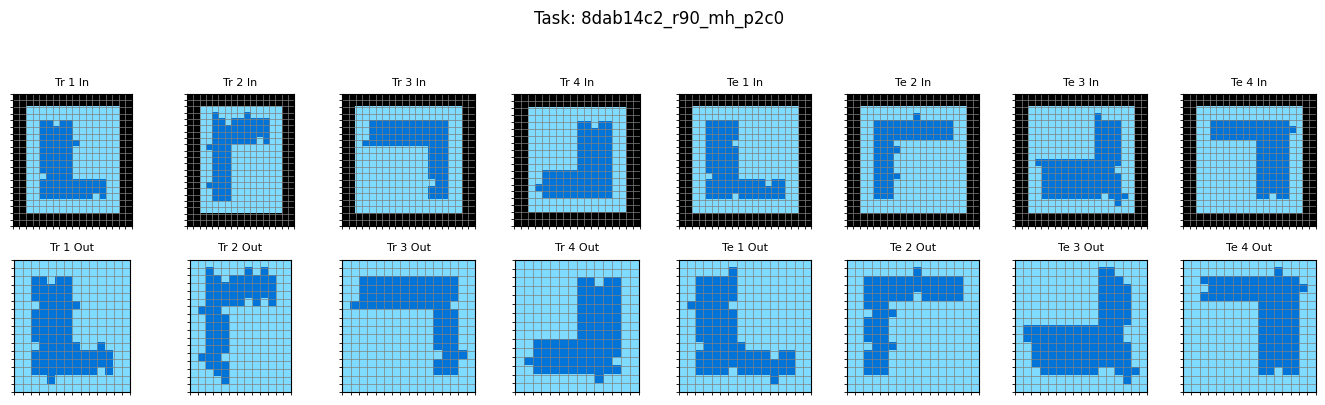


--- Visualizing first train example variants side-by-side for Task ID: 8dab14c2 ---
Found 15 variants to plot.


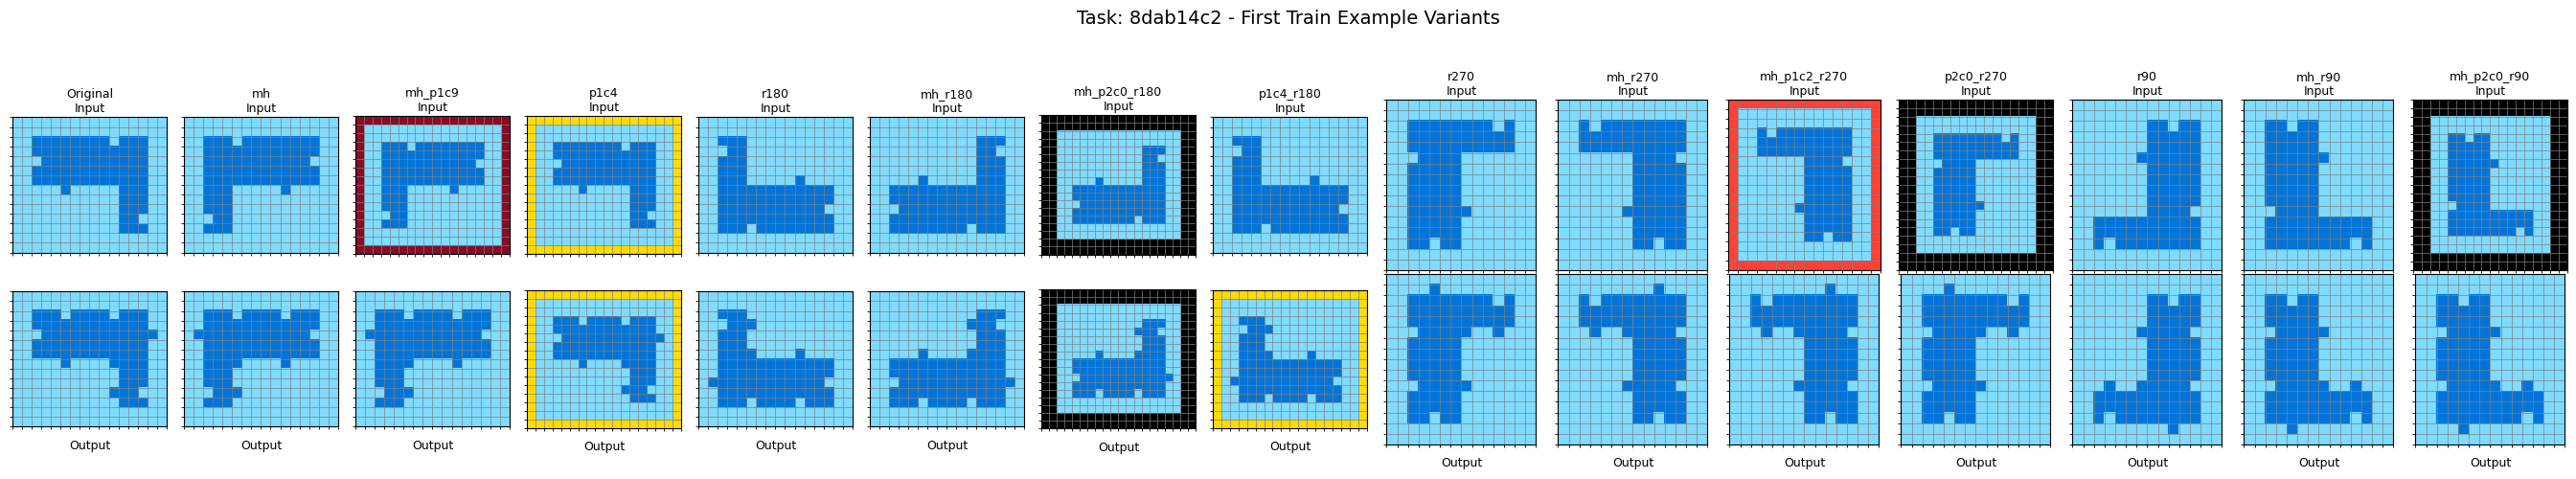

In [99]:
def pad_grid(grid, width, color):
    """Adds padding of a specific width and color around a grid."""
    # Assumes grid is valid list of lists and width > 0
    arr = np.array(grid, dtype=int)
    padded_arr = np.pad(arr, pad_width=width, mode='constant', constant_values=color)
    return padded_arr.tolist()

input_padding_probability = 0.5 
output_padding_probability = 0.5

print(f"Applying conditional padding to tasks in '{output_dir.name}'...")

all_task_files = sorted(output_dir.glob("*.json"))
padded_files_created = 0
for task_path in tqdm(all_task_files, desc="Padding tasks"):
    task_id_base = task_path.stem 
    if re.search(r'_p\d+c\d+$', task_id_base):
        continue

    pad_input_decision = random.random() < input_padding_probability
    pad_output_decision = random.random() < output_padding_probability
    if not pad_input_decision and not pad_output_decision:
        continue

    pad_width = random.randint(1, 2)
    pad_color = random.randint(0, 9)

    with open(task_path, 'r') as f:
        task_data = json.load(f)

    padded_data = {'train': [], 'test': []}
    for pair in task_data.get('train', []):
        input_grid = pair.get('input')
        output_grid = pair.get('output')
        padded_input = pad_grid(input_grid, pad_width, pad_color) if pad_input_decision and input_grid else input_grid
        padded_output = pad_grid(output_grid, pad_width, pad_color) if pad_output_decision and output_grid else output_grid
        padded_data['train'].append({'input': padded_input, 'output': padded_output})
        
    for pair in task_data.get('test', []):
        input_grid = pair.get('input')
        padded_input = pad_grid(input_grid, pad_width, pad_color) if pad_input_decision and input_grid else input_grid
        padded_pair = {'input': padded_input}
        if 'output' in pair:
            output_grid = pair.get('output')
            padded_pair['output'] = pad_grid(output_grid, pad_width, pad_color) if pad_output_decision and output_grid else output_grid
        padded_data['test'].append(padded_pair)

    pad_filename = f"{task_id_base}_p{pad_width}c{pad_color}.json"
    pad_filepath = output_dir / pad_filename
    with open(pad_filepath, 'w') as f_out:
        json.dump(padded_data, f_out)
    padded_files_created += 1

print(f"\nConditional Padding complete. Created {padded_files_created} new padded files.")
print(f"Total files in '{output_dir.name}': {count_json_files(output_dir)}")

# Visualize variants after padding
visualize_task_variants(example_vis_id, output_dir)

# Visualize side-by-side comparison after padding
plot_first_train_example_variants(example_vis_id, output_dir)

## 5. Structural Change: Split Multi-Test Tasks

Split tasks with more than one test example into separate files, removing the original multi-test file.

Checking for and splitting tasks with multiple test examples in 'modded_tasks'...
Split check pass: examining 13999 files...


Split check pass: examining 2028 files...



Splitting complete.
  - Original files needing split: 962
  - New single-test files created: 2028
  - Original multi-test files removed: 962
Total files in 'modded_tasks' now: 15065

Visualizing a split version of task 8dab14c2:


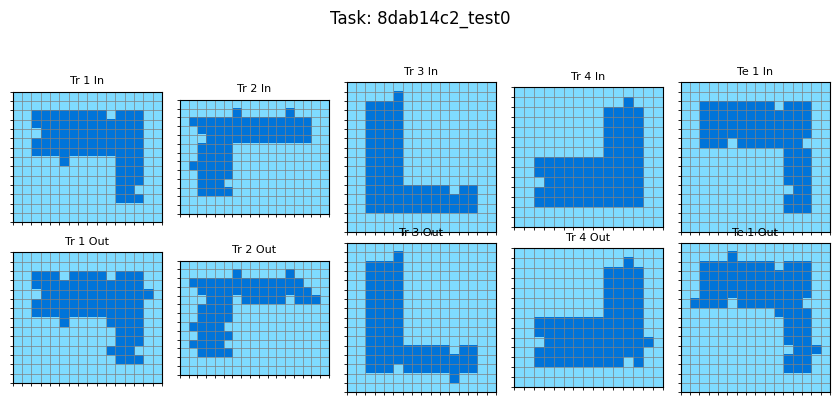

In [100]:
print(f"Checking for and splitting tasks with multiple test examples in '{output_dir.name}'...")

files_to_split_count = 0
new_files_created_count = 0
original_files_removed_count = 0
files_processed = set() 
split_task_examples = [] # Store names of successfully split tasks

while True:
    # Find files not yet processed in this splitting session
    files_to_check = sorted([f for f in output_dir.glob("*.json") if f.name not in files_processed])
    if not files_to_check:
        break 
        
    split_occurred_in_pass = False
    print(f"Split check pass: examining {len(files_to_check)} files...")
    for task_path in tqdm(files_to_check, desc="Splitting multi-test tasks (pass)", leave=False):
        files_processed.add(task_path.name) 
        task_id_base = task_path.stem 
        
        with open(task_path, 'r') as f:
            task_data = json.load(f)
        
        train_examples = task_data.get('train', [])
        test_examples = task_data.get('test', [])
        num_test_examples = len(test_examples)

        if num_test_examples > 1:
            files_to_split_count += 1
            split_occurred_in_pass = True
            
            for i, test_pair in enumerate(test_examples):
                split_task_data = {
                    'train': train_examples,
                    'test': [test_pair] 
                }
                new_filename = f"{task_id_base}_test{i}.json" 
                new_filepath = output_dir / new_filename
                with open(new_filepath, 'w') as f_out:
                    json.dump(split_task_data, f_out)
                new_files_created_count += 1
                if task_id_base == example_vis_id: # Store for later viz
                     split_task_examples.append(new_filepath)
            
            # Remove the original file
            task_path.unlink() 
            original_files_removed_count += 1
            
    if not split_occurred_in_pass:
        break

print(f"\nSplitting complete.")
print(f"  - Original files needing split: {files_to_split_count}") 
print(f"  - New single-test files created: {new_files_created_count}")
print(f"  - Original multi-test files removed: {original_files_removed_count}")
print(f"Total files in '{output_dir.name}' now: {count_json_files(output_dir)}")

# Visualize one of the split tasks if our example task was split
if split_task_examples:
    print(f"\nVisualizing a split version of task {example_vis_id}:")
    visualize_task_from_path(split_task_examples[0])


## 6. Duplicate Tasks for Shuffling Variation

Duplicate every task file, adding a `_c` suffix. This allows independent random shuffling in the next steps.

Duplicating all current task files in 'modded_tasks'...
Found 15065 files to duplicate.


Duplicating tasks: 100%|██████████| 15065/15065 [00:24<00:00, 603.55it/s]



Duplication complete. Created 15065 copies.
Total files in 'modded_tasks' now: 30130 (Expected: 30130)

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 120 variants.
(Showing first 20)


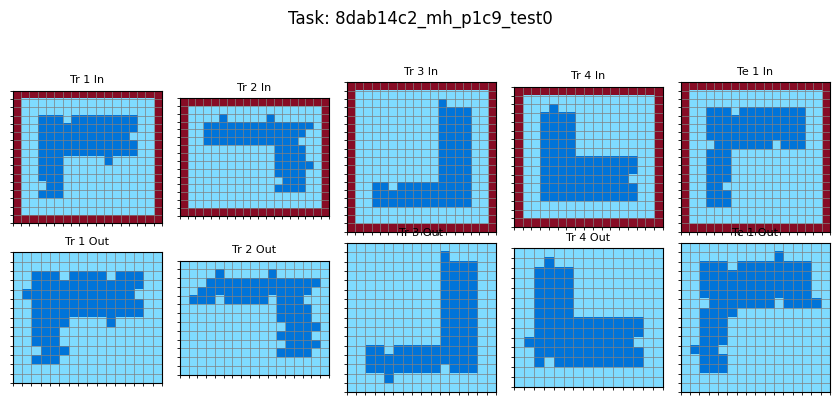

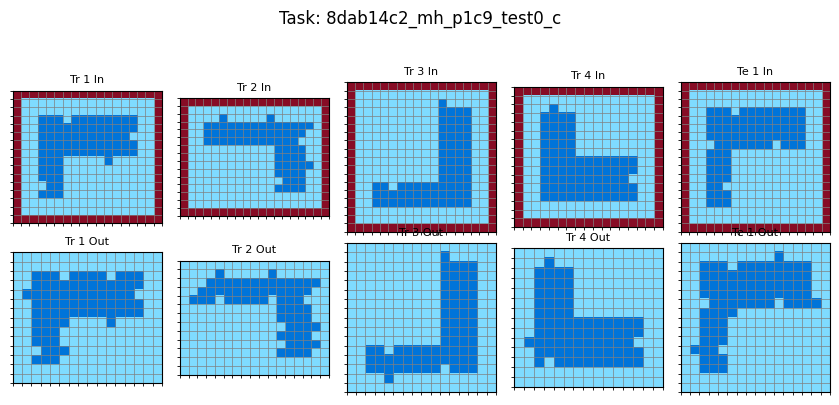

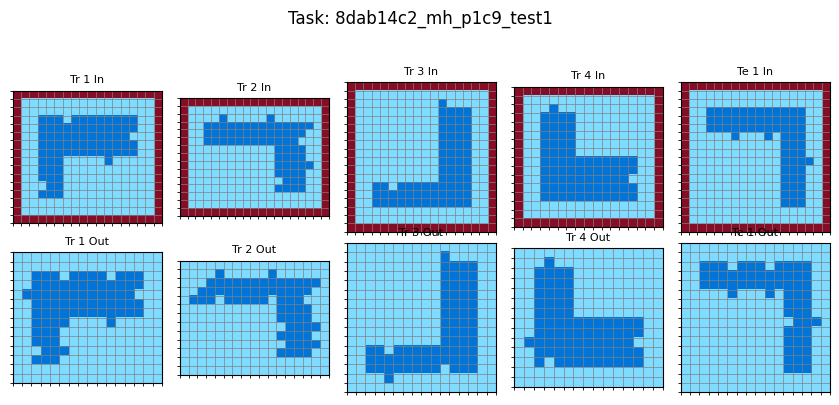

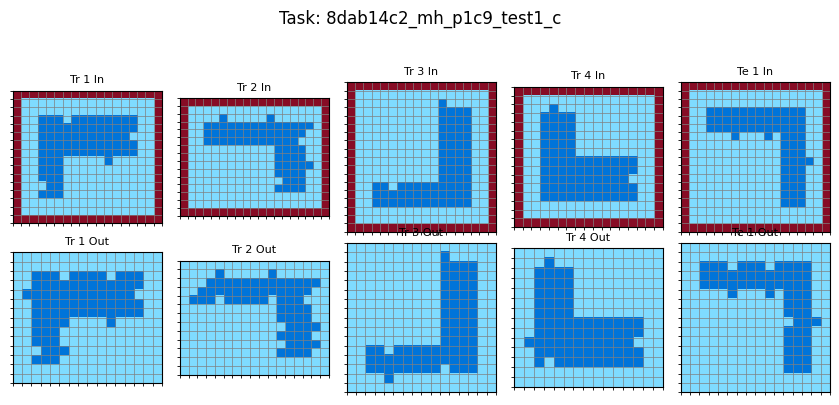

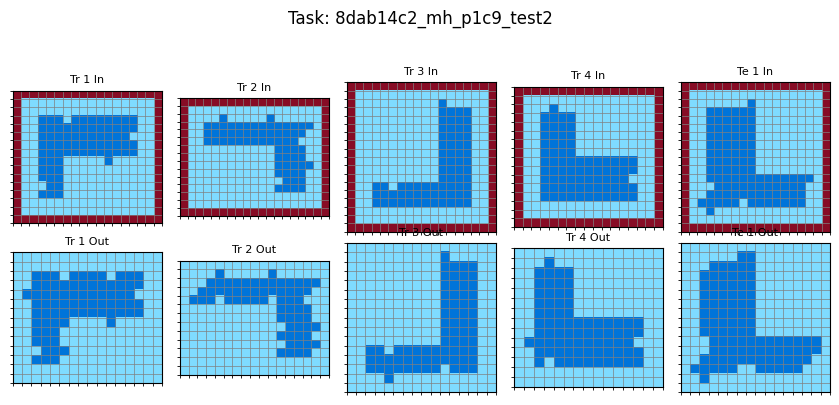

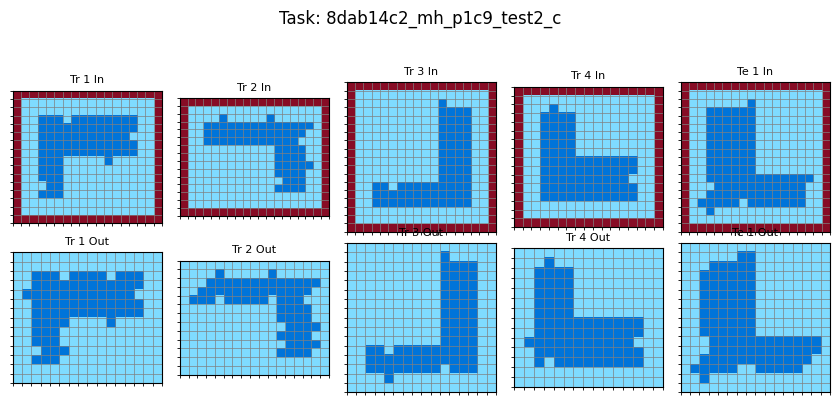

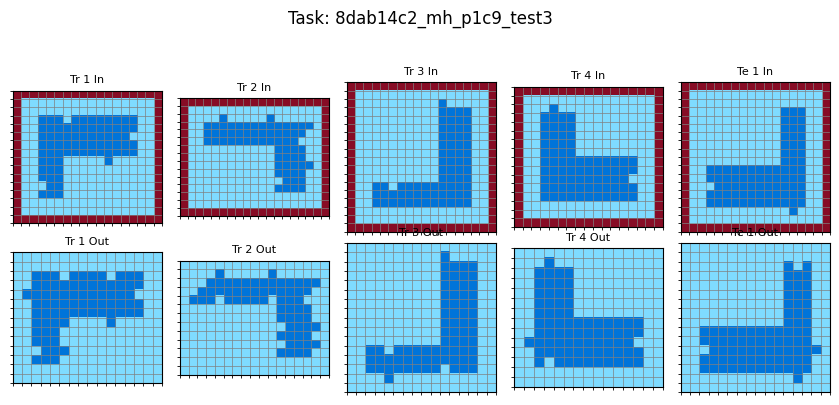

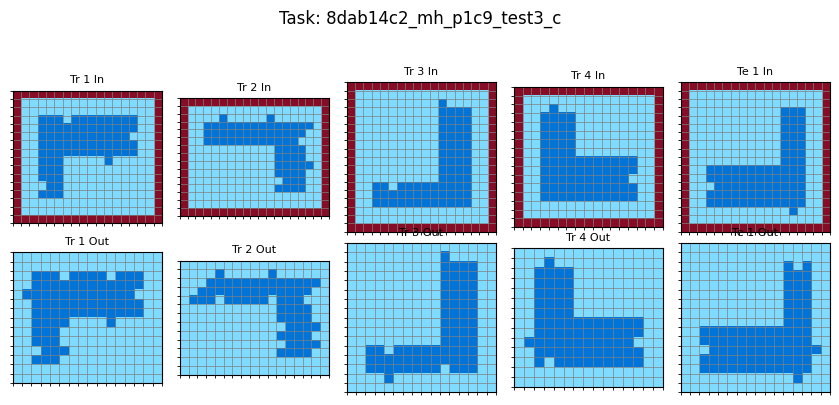

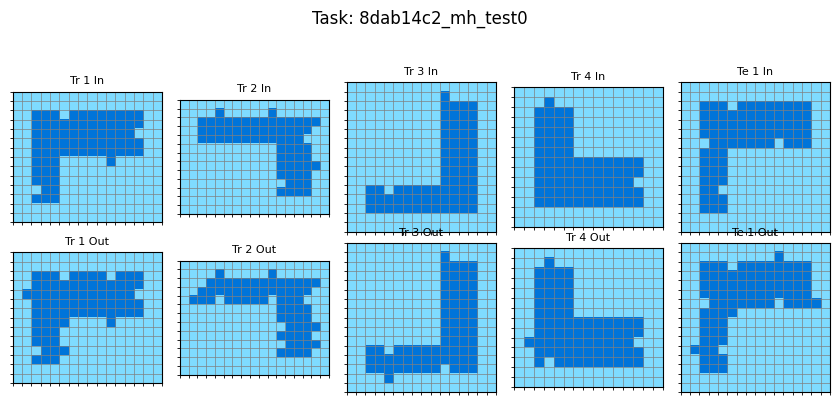

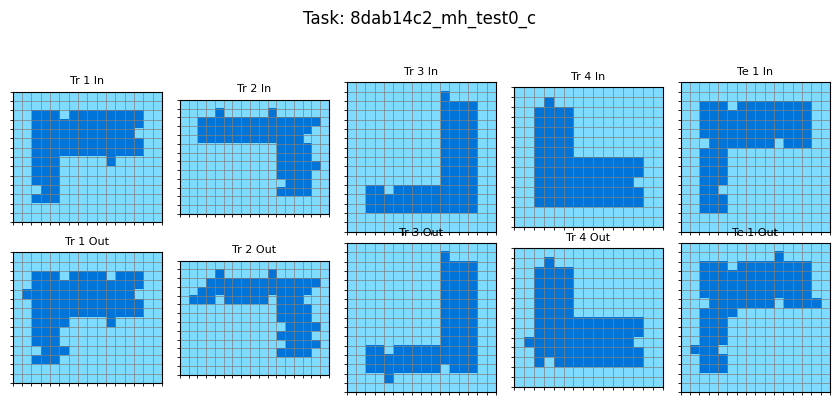

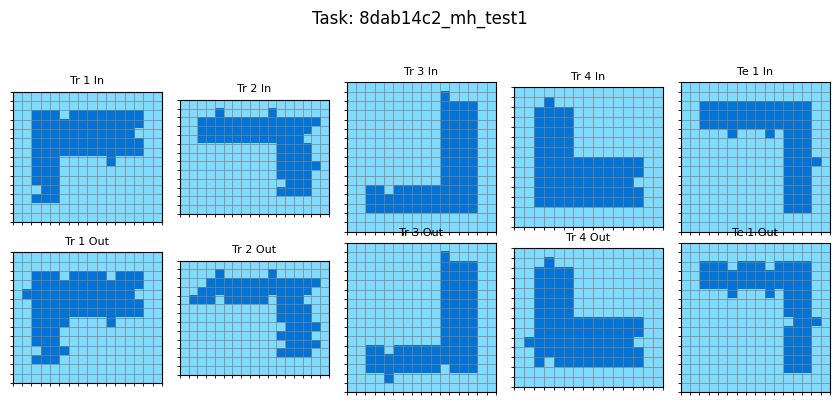

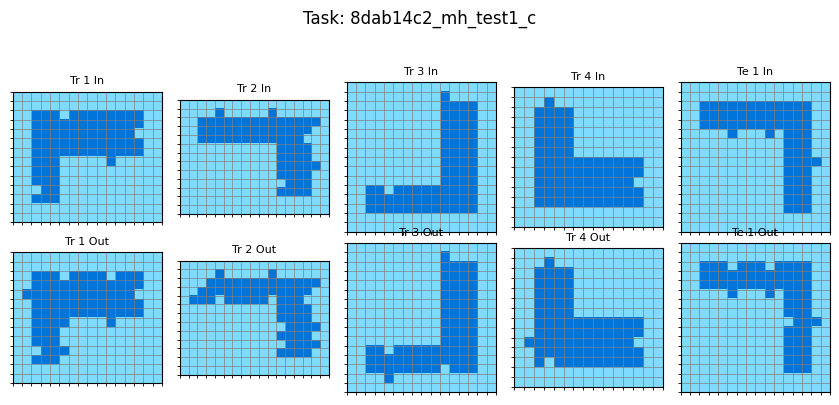

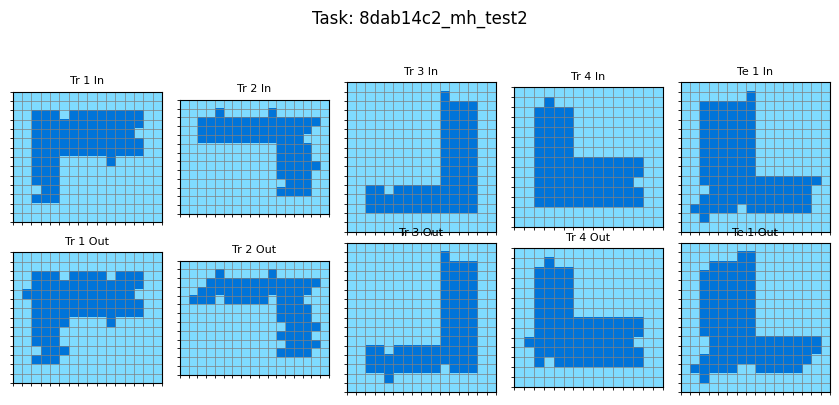

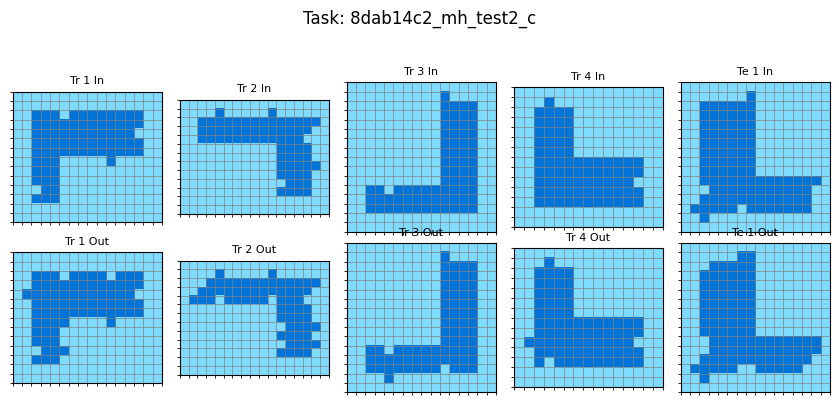

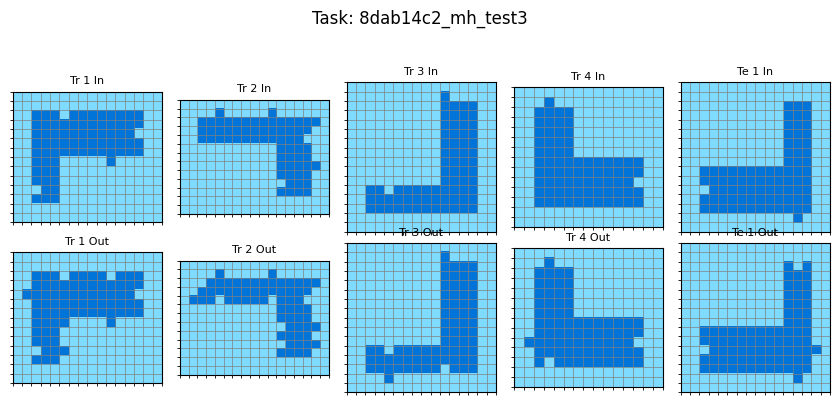

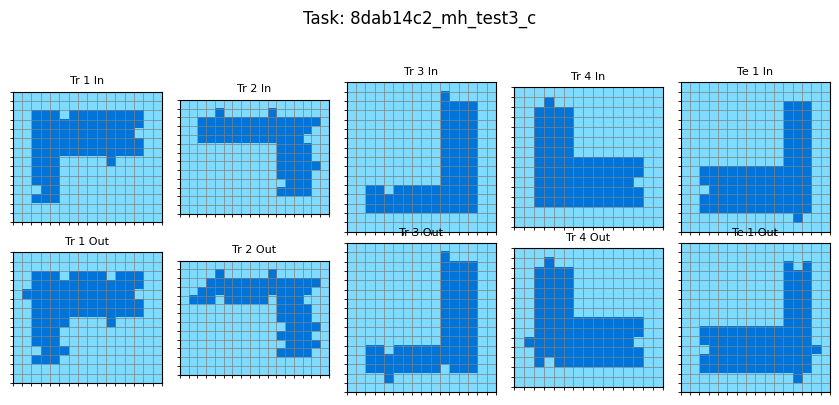

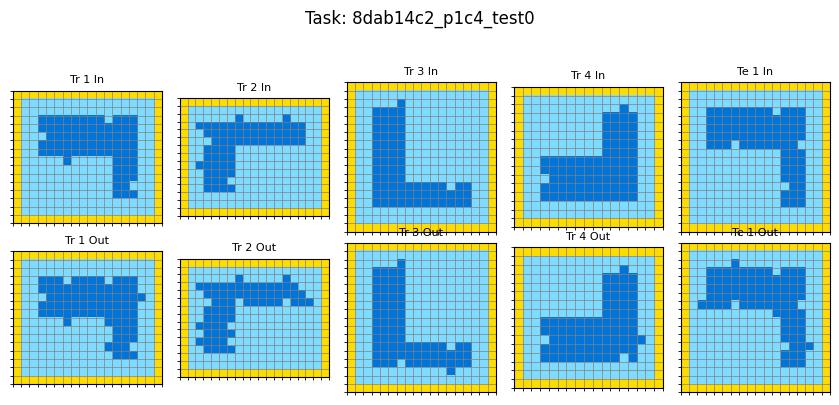

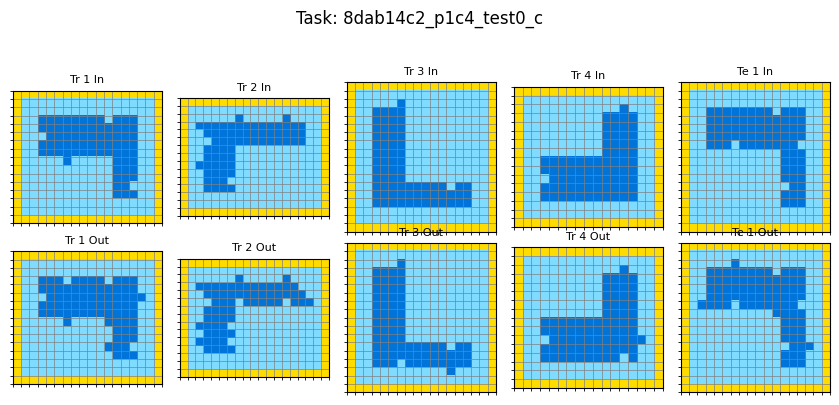

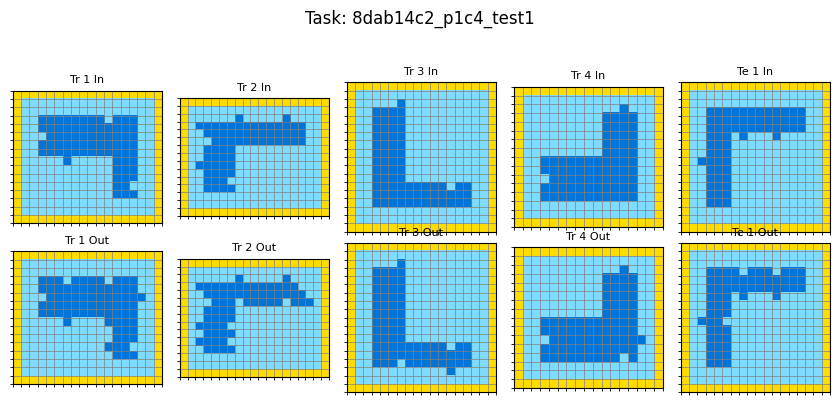

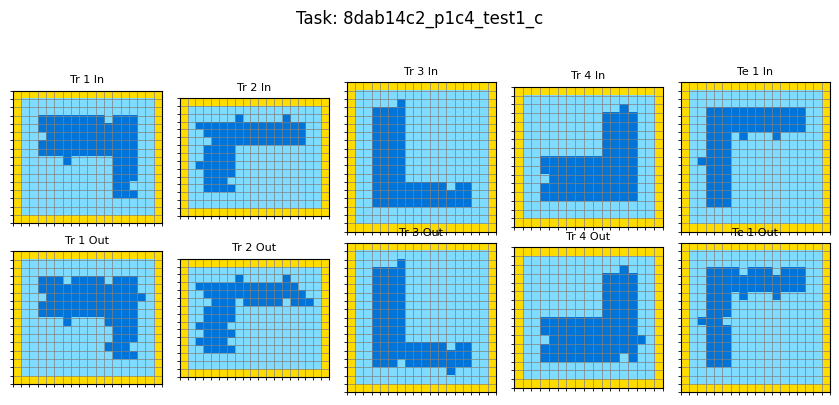

In [101]:
print(f"Duplicating all current task files in '{output_dir.name}'...")

files_to_duplicate = sorted(list(output_dir.glob("*.json")))
initial_count = len(files_to_duplicate)
print(f"Found {initial_count} files to duplicate.")

duplicates_created = 0
for task_path in tqdm(files_to_duplicate, desc="Duplicating tasks"):
    src = task_path
    new_filename = f"{task_path.stem}_c.json"
    dst = output_dir / new_filename
    shutil.copy2(src, dst)
    duplicates_created += 1

print(f"\nDuplication complete. Created {duplicates_created} copies.")
final_count = count_json_files(output_dir)
print(f"Total files in '{output_dir.name}' now: {final_count} (Expected: {initial_count * 2})")

# Visualize variants after duplication (will include _c files)
visualize_task_variants(example_vis_id, output_dir)


## 7. Randomization: Color Shuffling

Apply an independent, random color shuffle to every task file (including `_c` duplicates) in-place.

Applying random color shuffle (in-place) to ALL tasks in 'modded_tasks'...


Applying color shuffle: 100%|██████████| 30130/30130 [02:59<00:00, 167.75it/s]



Color shuffling complete. Modified 30130 files in-place.
Total files in 'modded_tasks' remains: 30130

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 120 variants.
(Showing first 20)


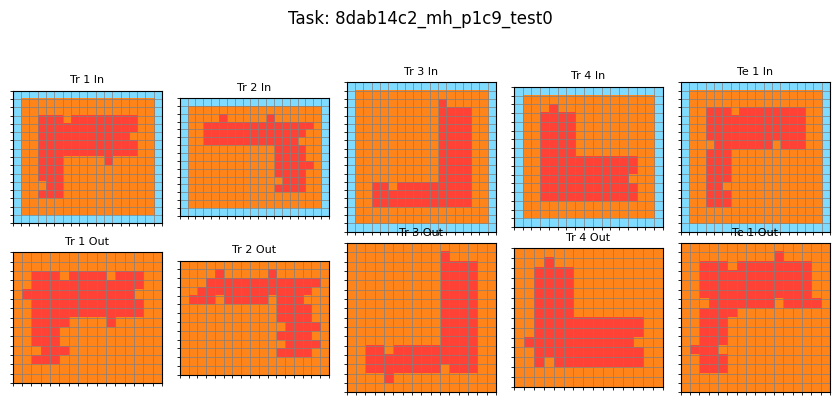

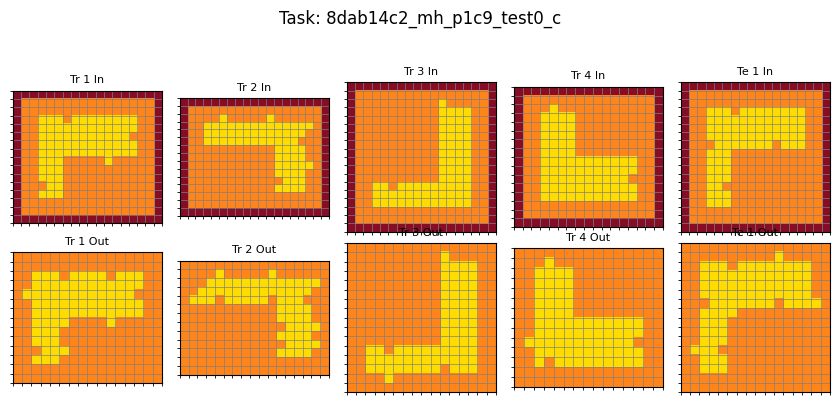

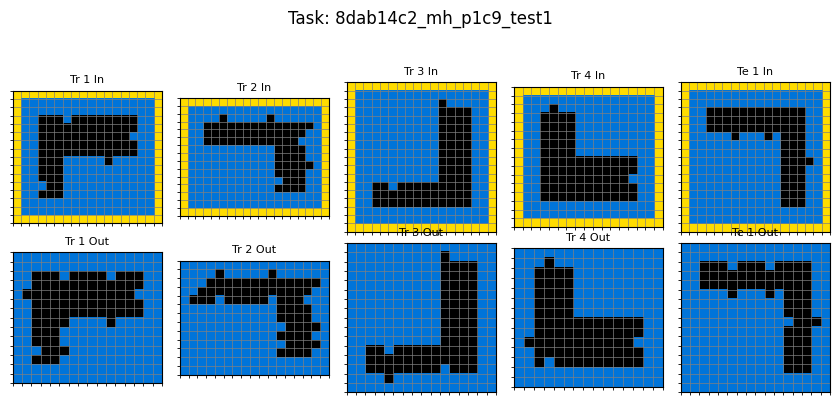

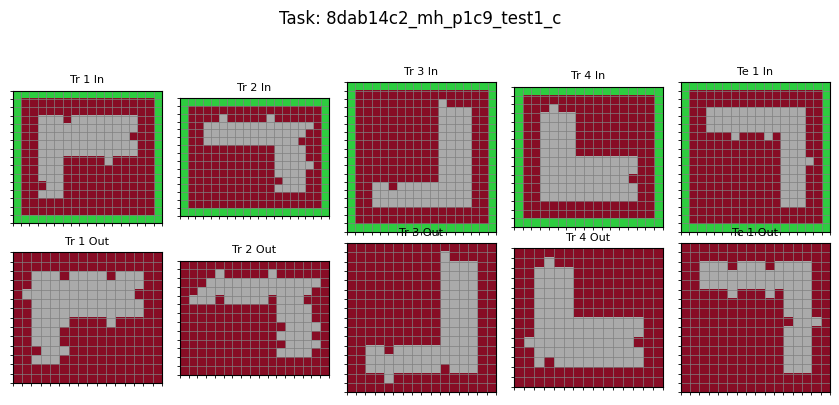

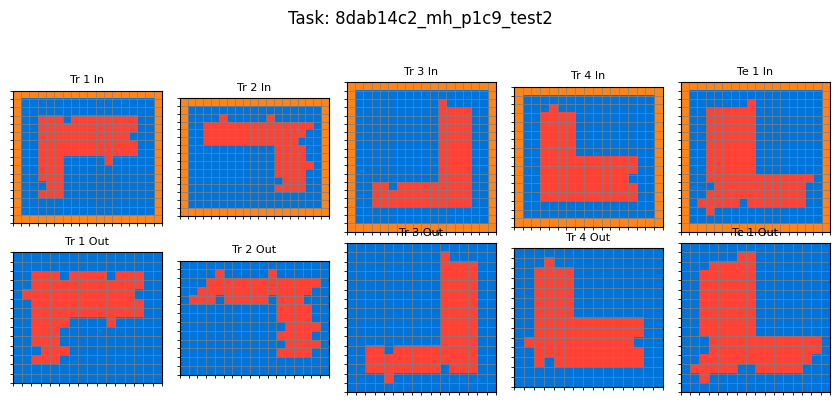

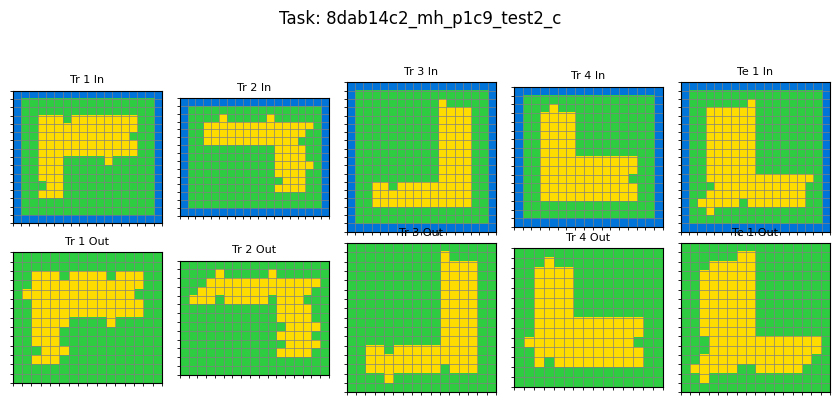

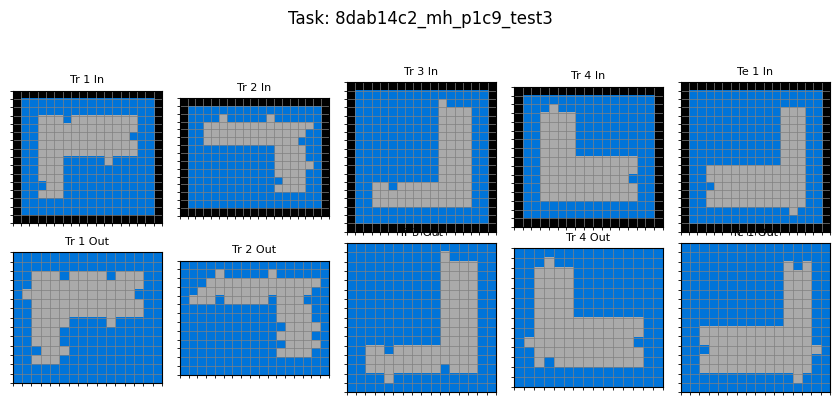

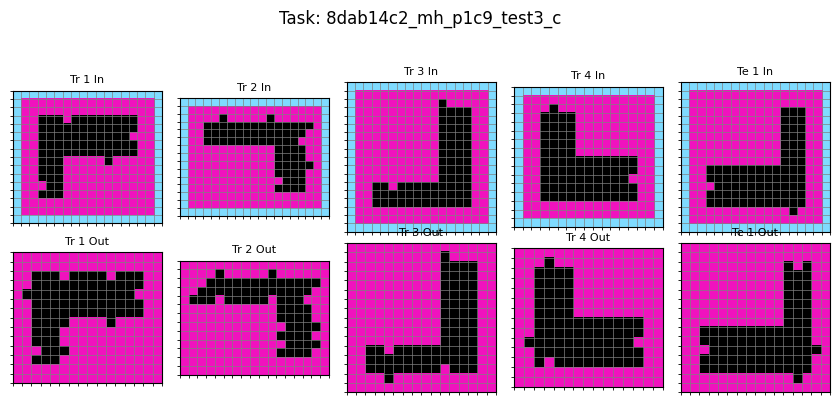

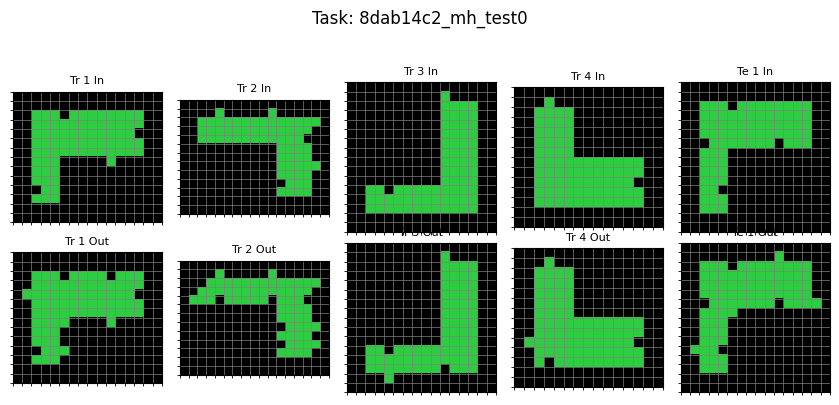

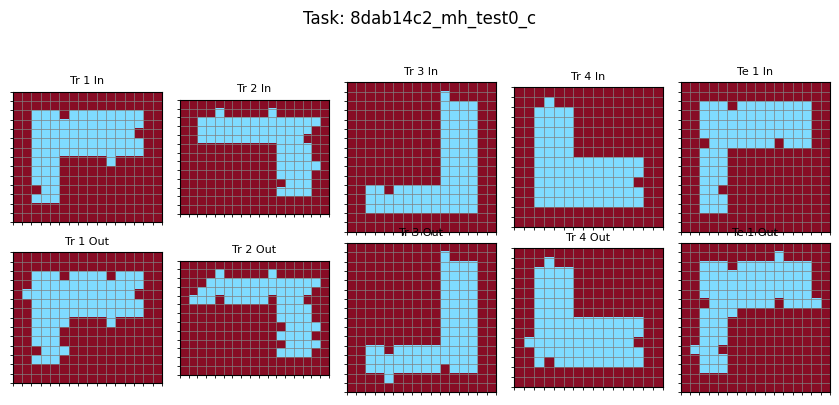

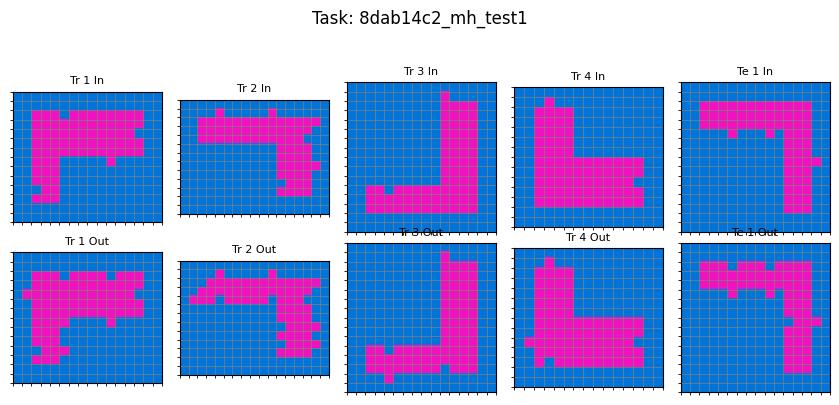

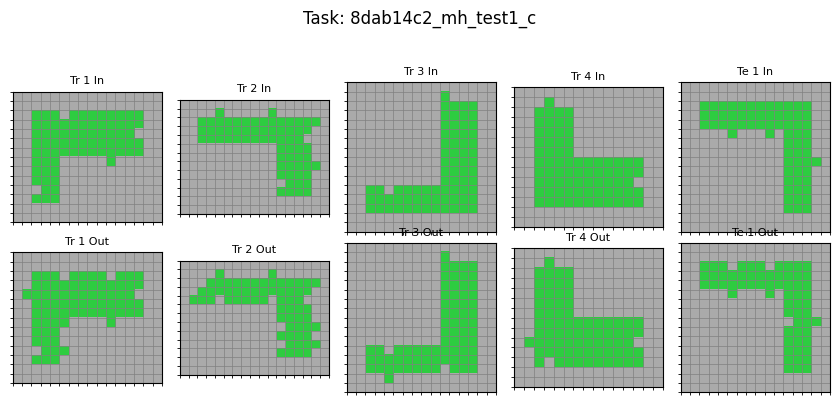

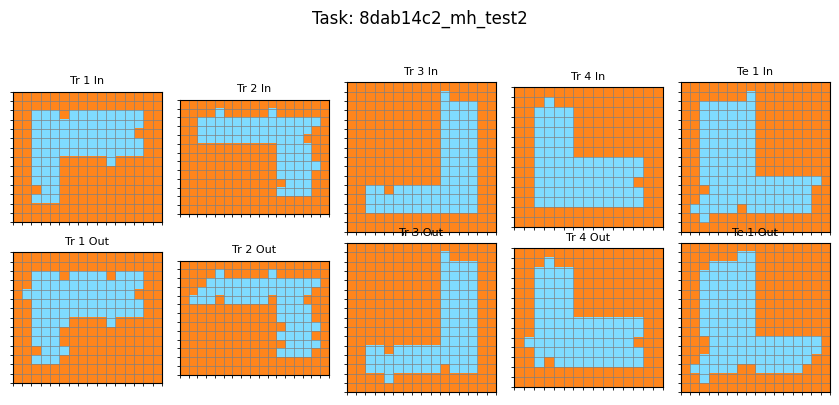

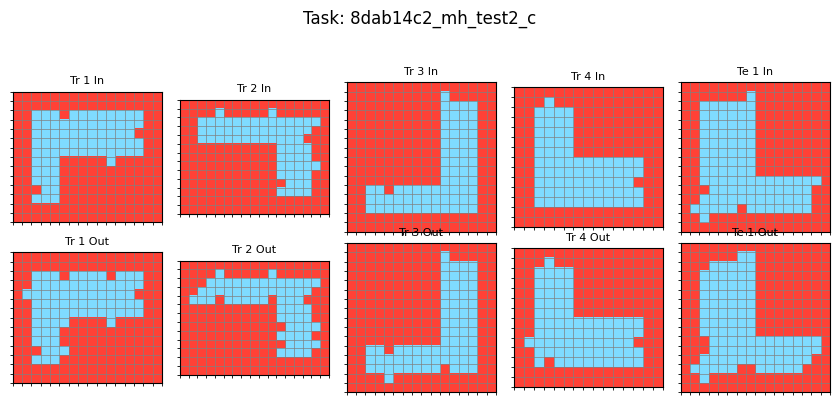

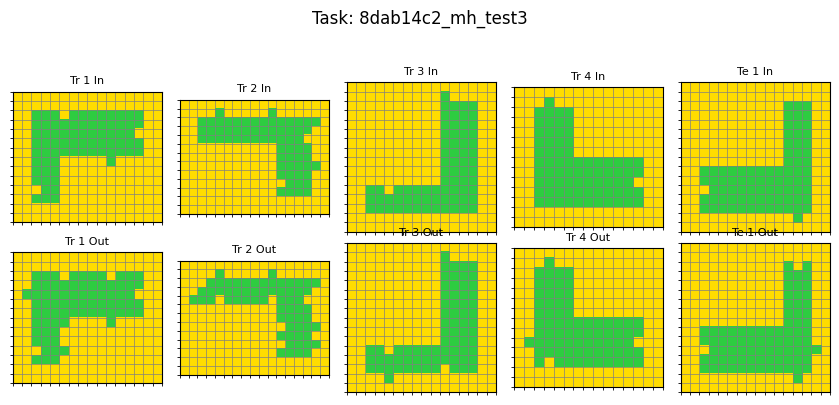

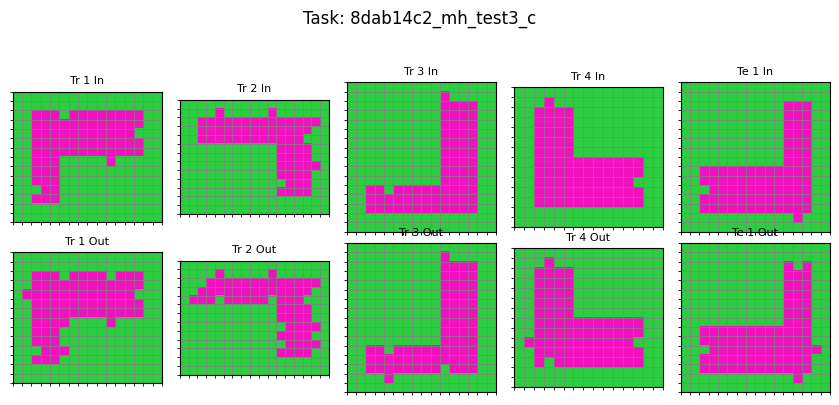

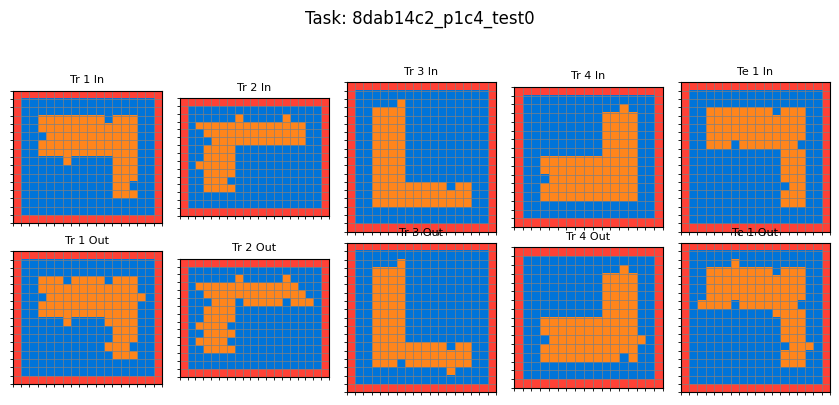

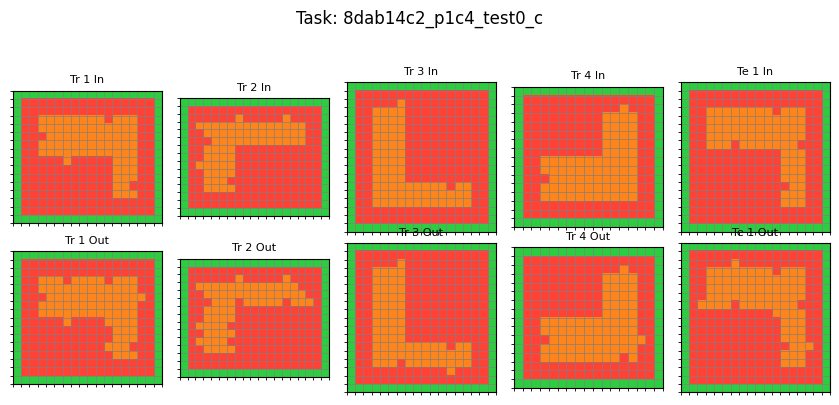

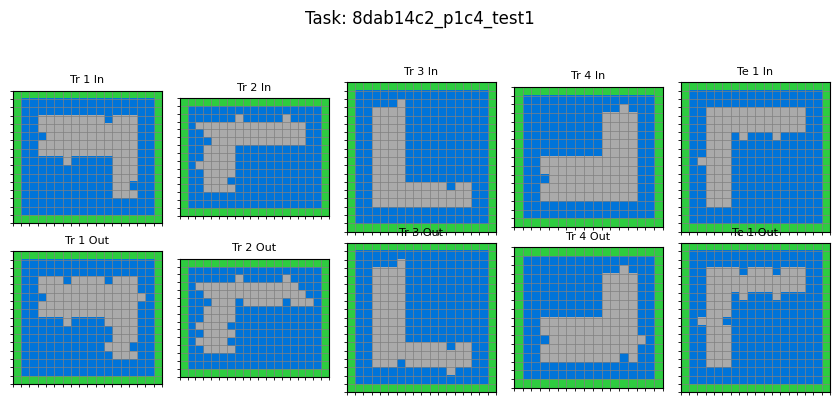

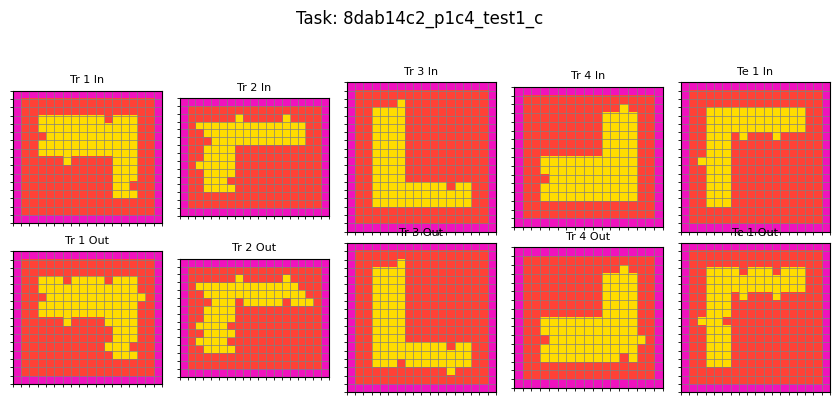


--- Visualizing first train example variants side-by-side for Task ID: 8dab14c2 ---
Found 120 variants to plot.


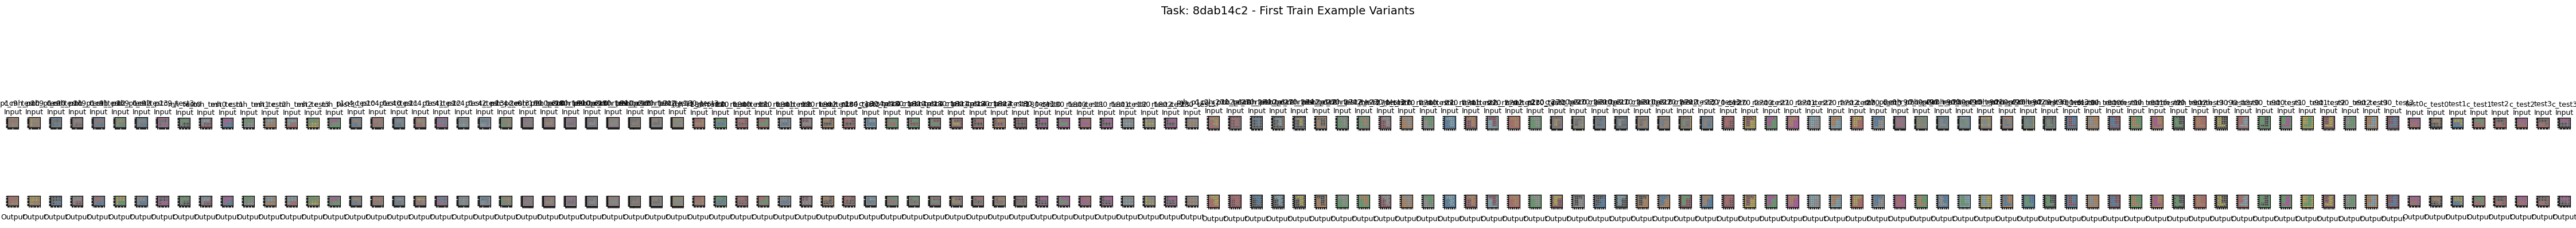

In [102]:
print(f"Applying random color shuffle (in-place) to ALL tasks in '{output_dir.name}'...")

all_json_files = sorted(list(output_dir.glob("*.json")))

files_shuffled_count = 0
for task_path in tqdm(all_json_files, desc="Applying color shuffle"):
    original_colors = list(range(10))
    shuffled_colors = original_colors[:]
    random.shuffle(shuffled_colors)
    color_map = {original: shuffled for original, shuffled in zip(original_colors, shuffled_colors)}

    with open(task_path, 'r') as f:
        task_data = json.load(f) 

    for key in ['train', 'test']:
        for pair in task_data.get(key, []): 
            if 'input' in pair and pair['input']:
                pair['input'] = [[color_map[cell] for cell in row] for row in pair['input']]
            if 'output' in pair and pair['output']:
                pair['output'] = [[color_map[cell] for cell in row] for row in pair['output']]

    with open(task_path, 'w') as f_out:
        json.dump(task_data, f_out) 
    files_shuffled_count += 1

print(f"\nColor shuffling complete. Modified {files_shuffled_count} files in-place.")
print(f"Total files in '{output_dir.name}' remains: {count_json_files(output_dir)}")

# Visualize variants after color shuffling
visualize_task_variants(example_vis_id, output_dir)

# Visualize side-by-side comparison after color shuffling
# This should clearly show different color mappings for original vs _c files
plot_first_train_example_variants(example_vis_id, output_dir)

## 8. Randomization: Shuffle Training Examples

Shuffle the order of training examples within each task file (including `_c` duplicates) in-place.

Shuffling the order of training examples within tasks in 'modded_tasks'...


Shuffling train examples: 100%|██████████| 30130/30130 [02:44<00:00, 182.87it/s]



Train example shuffling complete.
  - Files with shuffled train examples: 30130
Total files in 'modded_tasks' remains: 30130

--- Visualizing variants for Task ID: 8dab14c2 in 'modded_tasks' ---
Found 120 variants.
(Showing first 20)


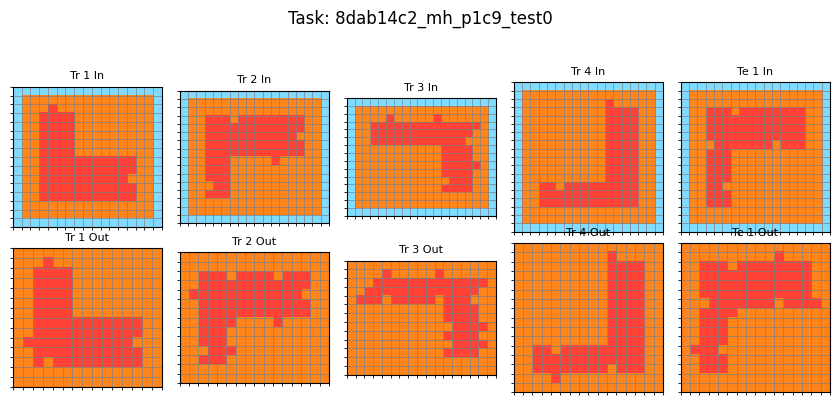

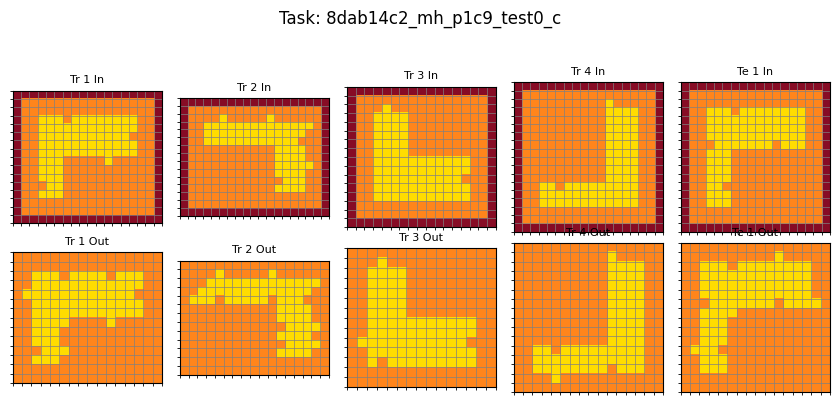

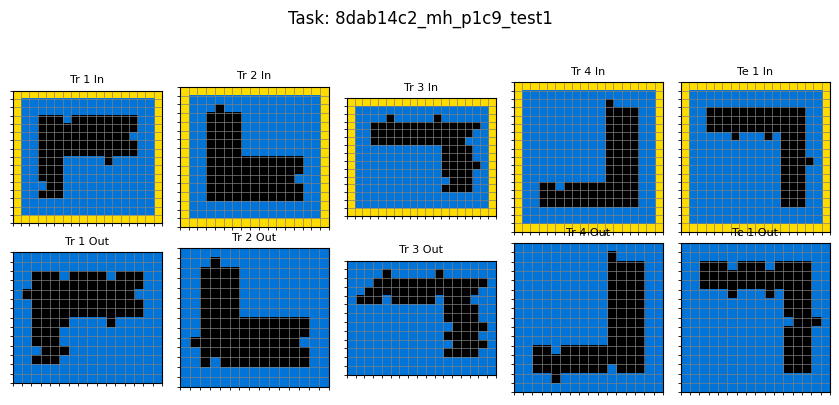

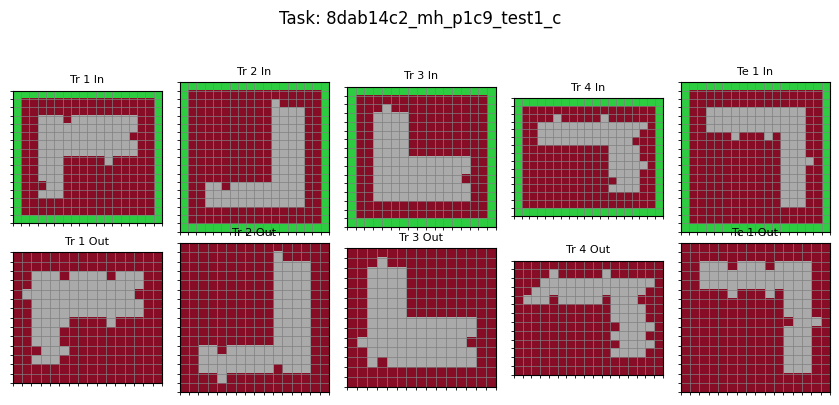

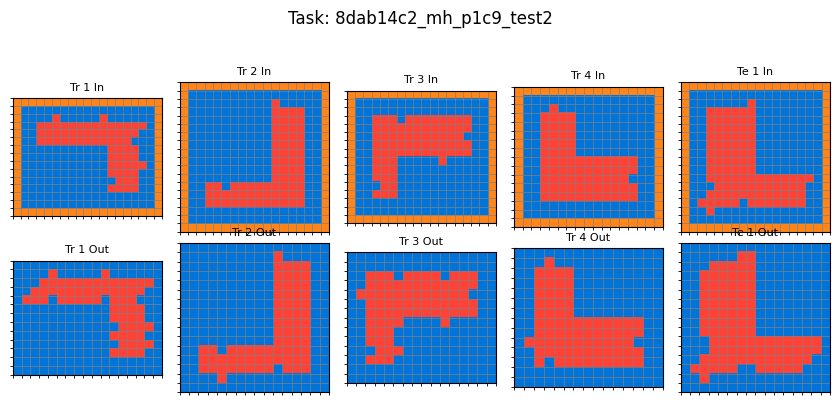

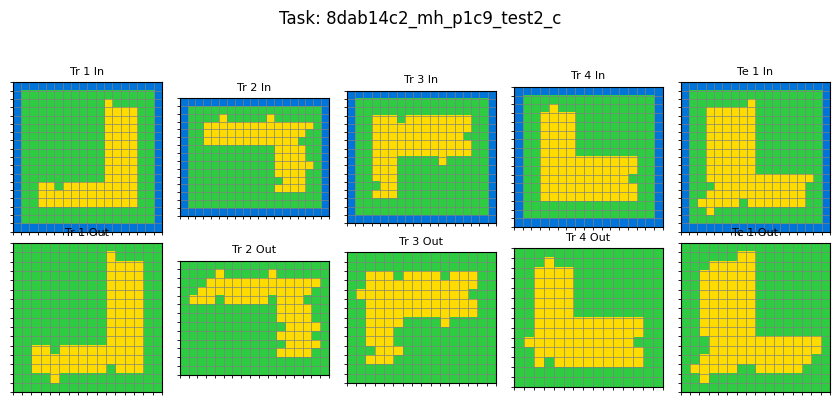

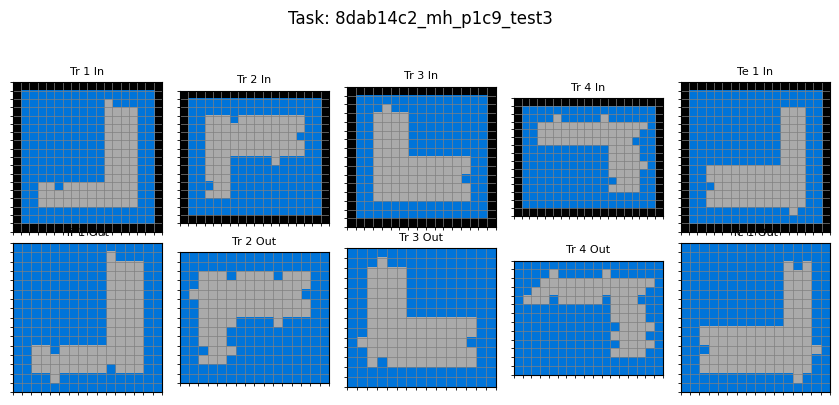

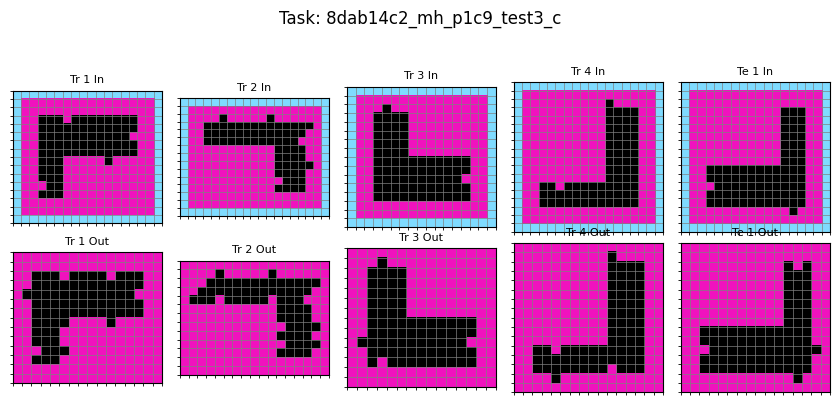

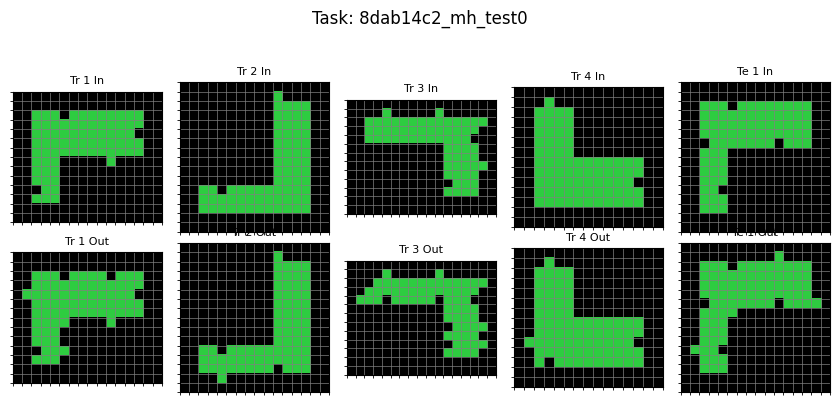

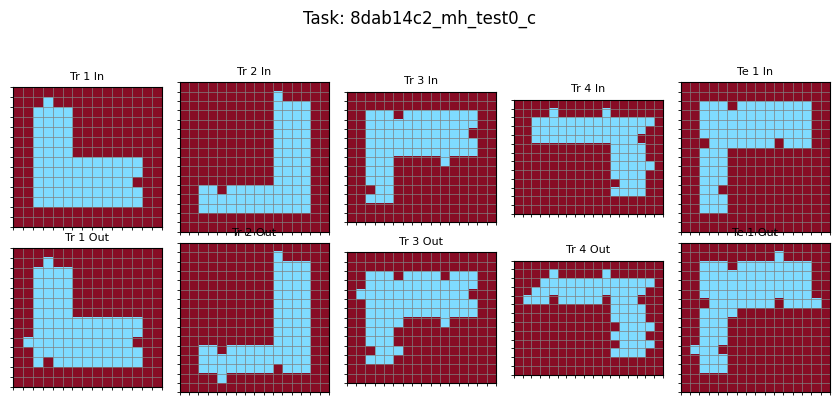

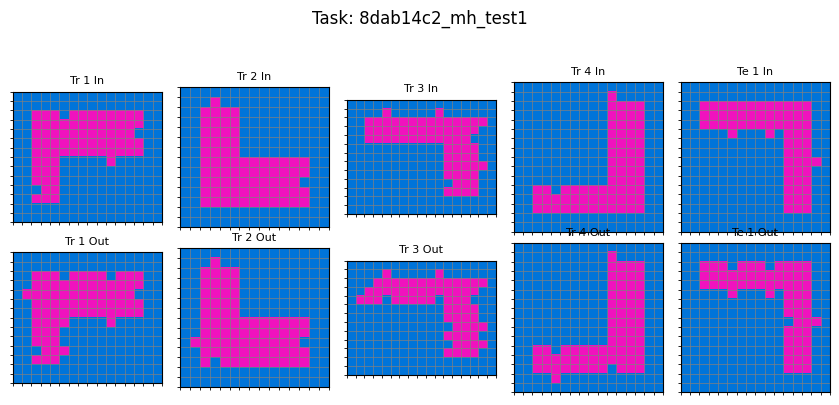

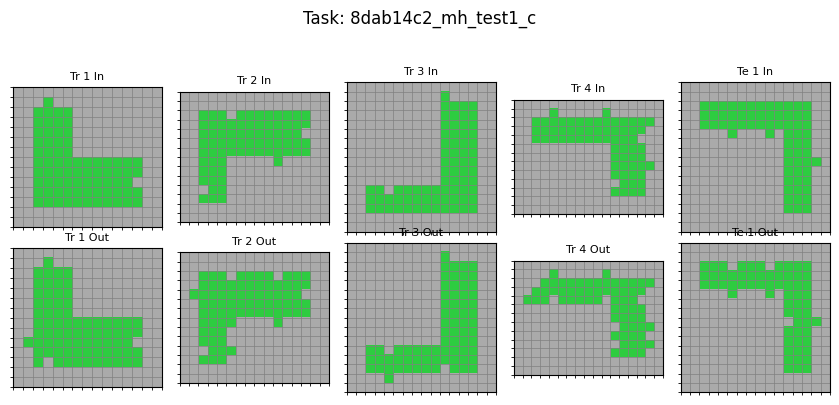

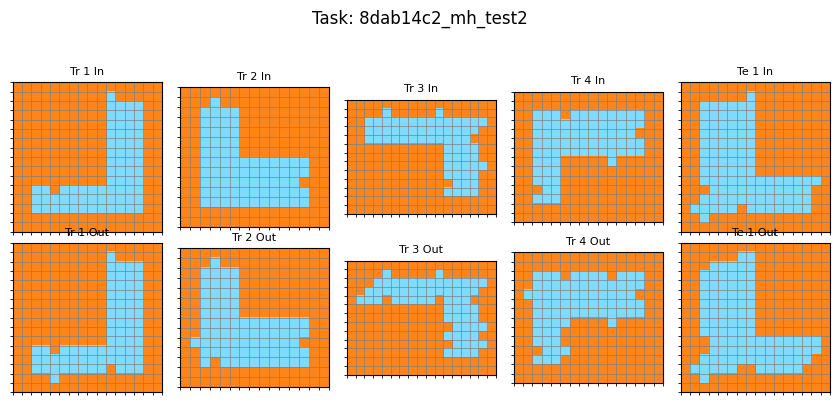

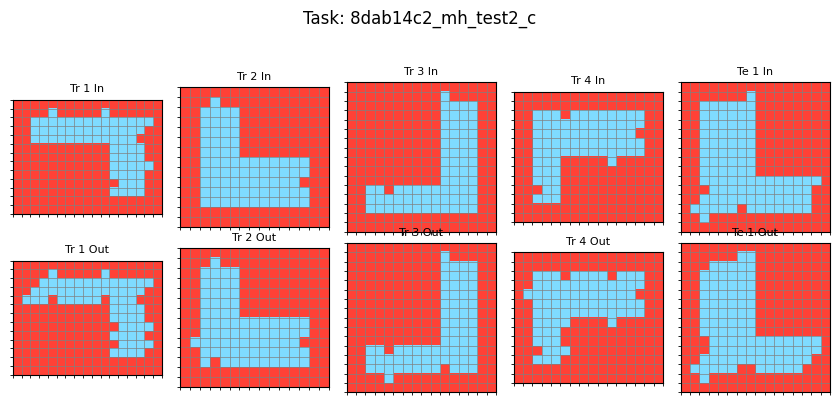

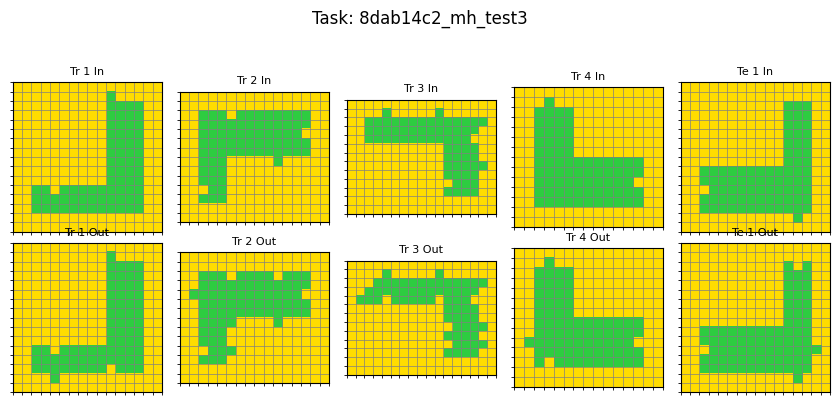

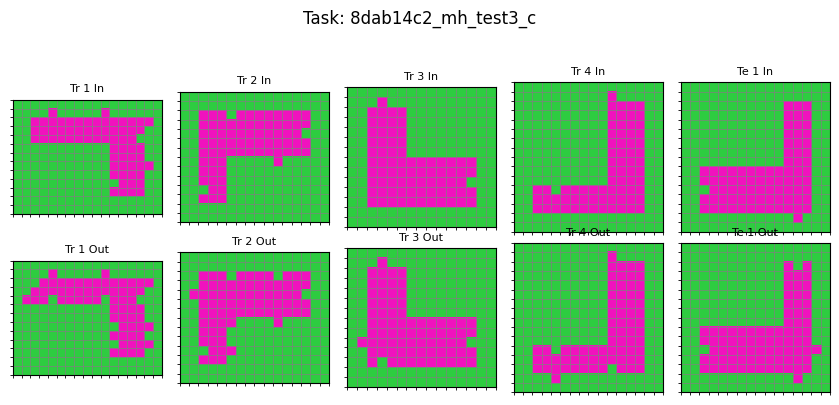

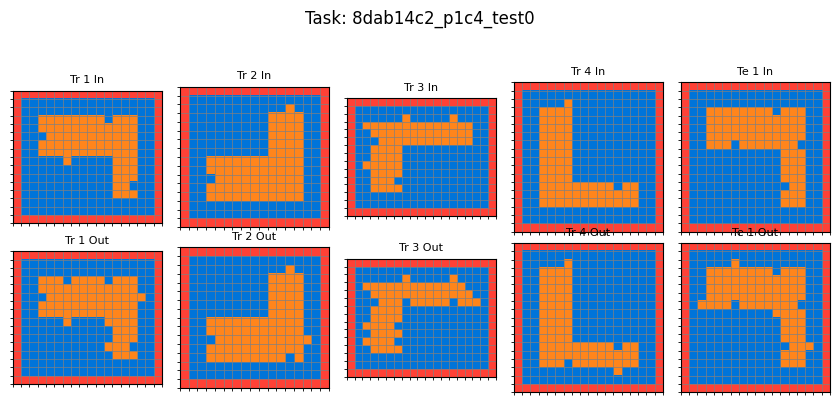

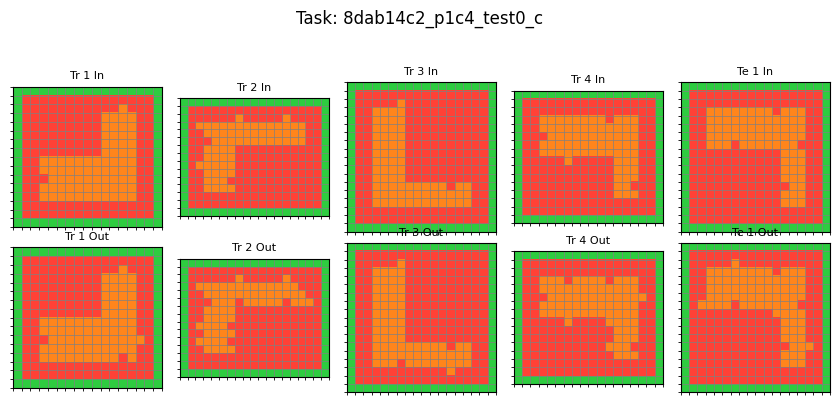

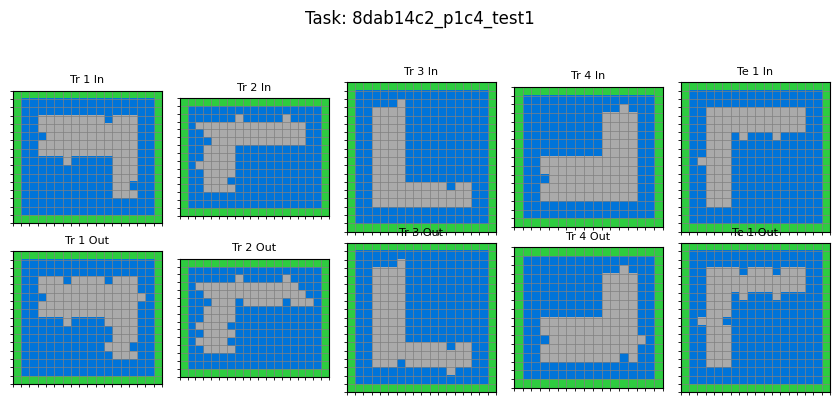

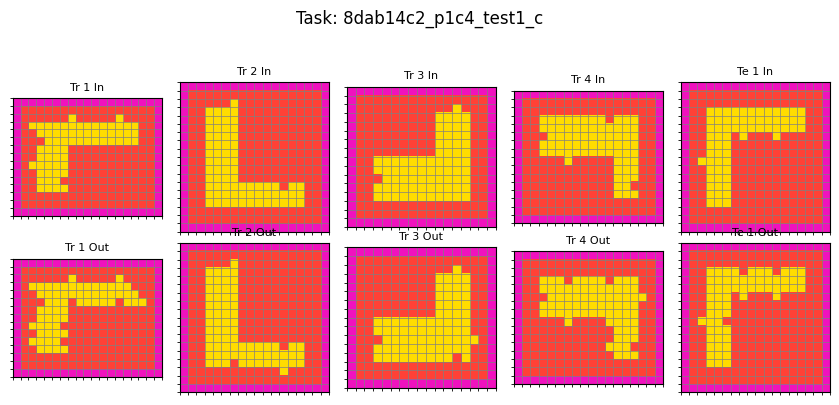


--- Visualizing first train example variants side-by-side for Task ID: 8dab14c2 ---
Found 120 variants to plot.


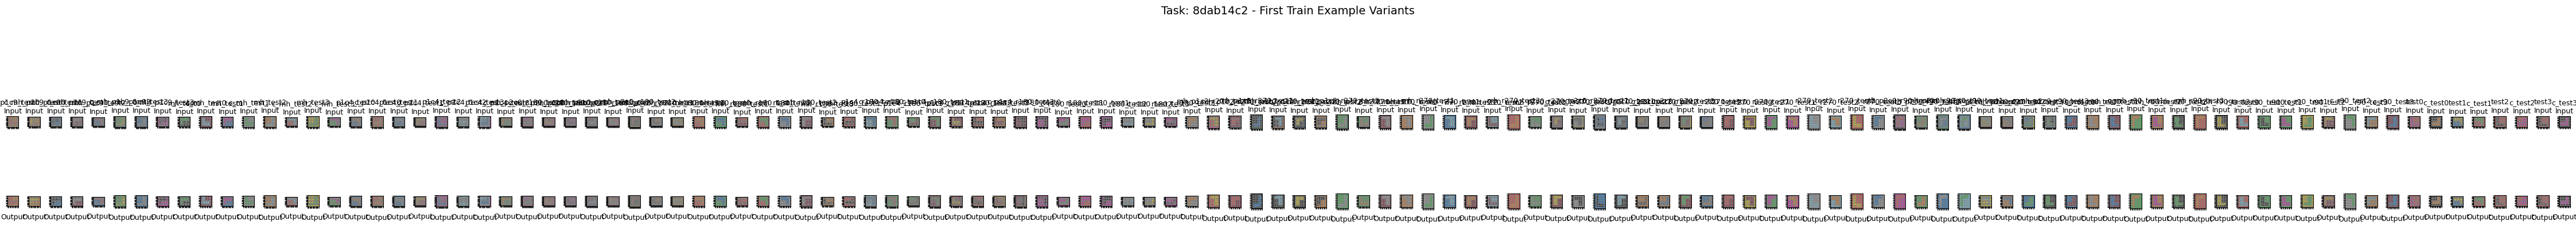

In [103]:
print(f"Shuffling the order of training examples within tasks in '{output_dir.name}'...")

all_json_files = sorted(list(output_dir.glob("*.json")))

shuffled_files_count = 0
for task_path in tqdm(all_json_files, desc="Shuffling train examples"):
    with open(task_path, 'r') as f:
        task_data = json.load(f)

    train_examples = task_data.get('train', [])
    if len(train_examples) > 1:
        random.shuffle(train_examples) 
        task_data['train'] = train_examples 
        with open(task_path, 'w') as f_out:
            json.dump(task_data, f_out)
        shuffled_files_count += 1

print(f"\nTrain example shuffling complete.")
print(f"  - Files with shuffled train examples: {shuffled_files_count}")
print(f"Total files in '{output_dir.name}' remains: {count_json_files(output_dir)}")

# Visualize variants after train shuffling
visualize_task_variants(example_vis_id, output_dir)

# Visualize side-by-side comparison after train shuffling
# The input/output grids will look the same as after color shuffle,
# but the *which* train example is shown first might differ between variants.
plot_first_train_example_variants(example_vis_id, output_dir)

## Final Check

The augmentation process is complete. The `modded_tasks` directory now contains the original tasks plus numerous augmented versions derived through rotation, mirroring, padding, test-splitting, duplication, color shuffling, and training example shuffling.

In [104]:
# --- Success Analysis Cell ---

import json
import os
from pathlib import Path
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np # For mean calculation

print("--- Starting Augmentation Success Analysis ---")

# Ensure paths are Path objects
data_dir = Path(data_dir)
output_dir = Path(output_dir)

# --- 1. Get Original Task Information ---
print(f"\n[1/5] Loading details from original tasks in: {data_dir}")
original_task_paths = sorted(data_dir.glob("*.json"))
original_task_ids = set()
original_task_details = {} # Store {id: {'train': count, 'test': count}}

for task_path in tqdm(original_task_paths, desc="Loading original tasks"):
    task_id = task_path.stem
    original_task_ids.add(task_id)
    with open(task_path, 'r') as f:
        data = json.load(f)
    original_task_details[task_id] = {
        'train': len(data.get('train', [])),
        'test': len(data.get('test', []))
    }
print(f"Found {len(original_task_ids)} unique original task IDs.")

# --- 2. Get Generated Task Information ---
print(f"\n[2/5] Analyzing generated tasks in: {output_dir}")
generated_files = sorted(output_dir.glob("*.json"))
total_generated_files = len(generated_files)
variants_per_base_id = defaultdict(list)
base_ids_found_in_output = set()

print(f"Found {total_generated_files} total .json files in the output directory.")
print("Mapping generated files back to original base IDs...")
for gen_path in tqdm(generated_files, desc="Mapping generated files"):
    # Extract base ID (assuming original IDs have no underscores)
    base_id = gen_path.stem.split('_')[0]
    variants_per_base_id[base_id].append(gen_path.name)
    base_ids_found_in_output.add(base_id)

print(f"Mapped generated files to {len(variants_per_base_id)} unique base IDs.")

# --- 3. Coverage and Multiplication Analysis ---
print("\n[3/5] Analyzing Task Coverage and Multiplication Factor...")

# Coverage Check
missing_ids = original_task_ids - base_ids_found_in_output
if not missing_ids:
    print("✅ SUCCESS: All original task IDs are present in the generated output.")
else:
    print(f"⚠️ WARNING: {len(missing_ids)} original task IDs seem to be missing from the output:")
    print(f"   {', '.join(sorted(list(missing_ids))[:10])}{'...' if len(missing_ids) > 10 else ''}")

# Check if any unexpected base IDs were found (e.g., corrupted filenames)
unexpected_base_ids = base_ids_found_in_output - original_task_ids
if unexpected_base_ids:
     print(f"⚠️ WARNING: Found {len(unexpected_base_ids)} unexpected base IDs in output filenames:")
     print(f"   {', '.join(sorted(list(unexpected_base_ids))[:10])}{'...' if len(unexpected_base_ids) > 10 else ''}")


# Multiplication Factor Analysis
num_variants_list = [len(variants) for variants in variants_per_base_id.values()]

if not num_variants_list:
    print("No variants found, cannot calculate multiplication factor.")
    avg_multiplication = 0
    min_variants = 0
    max_variants = 0
    tasks_with_min = []
    tasks_with_max = []
else:
    avg_multiplication = np.mean(num_variants_list)
    min_variants = min(num_variants_list)
    max_variants = max(num_variants_list)

    tasks_with_min = [base_id for base_id, variants in variants_per_base_id.items() if len(variants) == min_variants]
    tasks_with_max = [base_id for base_id, variants in variants_per_base_id.items() if len(variants) == max_variants]

    print(f"📊 Average multiplication factor per original task: {avg_multiplication:.2f} variants.")
    print(f"📉 Minimum number of variants for a single task: {min_variants}")
    print(f"   (Found for {len(tasks_with_min)} tasks, e.g., {tasks_with_min[0]})" if tasks_with_min else "")
    print(f"📈 Maximum number of variants for a single task: {max_variants}")
    print(f"   (Found for {len(tasks_with_max)} tasks, e.g., {tasks_with_max[0]})" if tasks_with_max else "")

# --- 4. Input/Output Pair Consistency Check ---
print("\n[4/5] Analyzing Input/Output Pair Consistency per Task File...")
train_mismatches = defaultdict(list)
test_mismatches = defaultdict(list)
files_analyzed_for_pairs = 0

print("Verifying train/test pair counts in generated files...")
for base_id, variants in tqdm(variants_per_base_id.items(), desc="Checking pair counts"):
    if base_id not in original_task_details:
        # This case should be caught by the 'unexpected_base_ids' check earlier
        continue 

    original_train_count = original_task_details[base_id]['train']
    original_test_count = original_task_details[base_id]['test']
    
    for variant_filename in variants:
        variant_path = output_dir / variant_filename
        files_analyzed_for_pairs += 1
        with open(variant_path, 'r') as f:
            variant_data = json.load(f)
        
        # Check Train examples
        generated_train_count = len(variant_data.get('train', []))
        if generated_train_count != original_train_count:
            train_mismatches[base_id].append({
                'file': variant_filename, 
                'expected': original_train_count, 
                'found': generated_train_count
            })
            
        # Check Test examples (AFTER split, should always be 1)
        generated_test_count = len(variant_data.get('test', []))
        # The only way it wouldn't be 1 is if the original had 0 test examples, 
        # or if splitting failed/didn't happen for some reason.
        # Since splitting removes originals with >1 test, all remaining/new should have 1.
        if generated_test_count != 1:
             # Let's refine this: if the original had 0 tests, 0 is expected. Otherwise, 1 is expected.
             expected_test_count = 1 if original_test_count > 0 else 0
             if generated_test_count != expected_test_count:
                 test_mismatches[base_id].append({
                     'file': variant_filename,
                     'expected': expected_test_count, # After split logic
                     'found': generated_test_count,
                     'original_test#': original_test_count 
                 })


print(f"Analyzed train/test pair counts for {files_analyzed_for_pairs} generated files.")
if not train_mismatches and not test_mismatches:
    print("✅ SUCCESS: All generated files have the expected number of train examples and exactly one test example (or zero if original had zero).")
else:
    if train_mismatches:
        print(f"⚠️ WARNING: Found {len(train_mismatches)} base tasks with train example count mismatches in some variants.")
        # Print details for the first few mismatches
        count = 0
        for base_id, mismatches in train_mismatches.items():
             print(f"  - Task {base_id}: Expected {mismatches[0]['expected']} train examples.")
             for mismatch in mismatches[:2]: # Show first 2 mismatches per task
                 print(f"    - File '{mismatch['file']}' found {mismatch['found']}")
             if len(mismatches) > 2: print("      ...")
             count+=1
             if count >= 3: # Limit overall output
                 print("  ...")
                 break
                 
    if test_mismatches:
         print(f"⚠️ WARNING: Found {len(test_mismatches)} base tasks with unexpected test example counts in some variants (Expected 1 after split, or 0 if original had 0).")
         # Print details for the first few mismatches
         count = 0
         for base_id, mismatches in test_mismatches.items():
             print(f"  - Task {base_id}: Expected {mismatches[0]['expected']} test examples (Original had {mismatches[0]['original_test#']}).")
             for mismatch in mismatches[:2]:
                 print(f"    - File '{mismatch['file']}' found {mismatch['found']}")
             if len(mismatches) > 2: print("      ...")
             count+=1
             if count >= 3:
                 print("  ...")
                 break

# --- 5. Final Summary ---
print("\n[5/5] Overall Summary:")
print("----------------------")
print(f"- Original Tasks: {len(original_task_ids)}")
print(f"- Generated Tasks: {total_generated_files}")
if len(original_task_ids) > 0:
    print(f"- Average Variants per Original: {total_generated_files / len(original_task_ids):.2f}")
else:
     print("- Average Variants per Original: N/A")
print(f"- Coverage: {'COMPLETE' if not missing_ids else f'INCOMPLETE ({len(missing_ids)} missing)'}")
print(f"- Train Pair Consistency: {'OK' if not train_mismatches else 'ISSUES FOUND'}")
print(f"- Test Pair Consistency (Post-Split): {'OK' if not test_mismatches else 'ISSUES FOUND'}")
print("\n--- Analysis Complete ---")

--- Starting Augmentation Success Analysis ---

[1/5] Loading details from original tasks in: ..\ARC-AGI\data\training


Loading original tasks: 100%|██████████| 1000/1000 [00:00<00:00, 2005.39it/s]


Found 1000 unique original task IDs.

[2/5] Analyzing generated tasks in: modded_tasks
Found 30130 total .json files in the output directory.
Mapping generated files back to original base IDs...


Mapping generated files: 100%|██████████| 30130/30130 [00:00<00:00, 567956.87it/s]


Mapped generated files to 1000 unique base IDs.

[3/5] Analyzing Task Coverage and Multiplication Factor...
✅ SUCCESS: All original task IDs are present in the generated output.
📊 Average multiplication factor per original task: 30.13 variants.
📉 Minimum number of variants for a single task: 20
   (Found for 2 tasks, e.g., 1a244afd)
📈 Maximum number of variants for a single task: 120
   (Found for 1 tasks, e.g., 8dab14c2)

[4/5] Analyzing Input/Output Pair Consistency per Task File...
Verifying train/test pair counts in generated files...


Checking pair counts: 100%|██████████| 1000/1000 [00:14<00:00, 67.78it/s]

Analyzed train/test pair counts for 30130 generated files.
✅ SUCCESS: All generated files have the expected number of train examples and exactly one test example (or zero if original had zero).

[5/5] Overall Summary:
----------------------
- Original Tasks: 1000
- Generated Tasks: 30130
- Average Variants per Original: 30.13
- Coverage: COMPLETE
- Train Pair Consistency: OK
- Test Pair Consistency (Post-Split): OK

--- Analysis Complete ---


--- End of Notebook ---